In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.optimize import curve_fit
import scipy.optimize as optimize

In [2]:
persons = ['A', 'B', 'C']
nums = [10, 25, 50, 100, 200, 500]
# nums = [10]

delete_list = ['Yindel', 'AMEL', 'DYS391', 'Amel']
reference = pd.read_csv('data/Refrence.csv')
# 计算每个个体的基因座上的等位基因
alleles_dict_list = []
for person in persons:
    A_refrence_data = reference[reference['sample'] == person]
    A_refrence_data = A_refrence_data[~A_refrence_data['marker'].isin(delete_list)]
    alleles_dict = {A_refrence_data['marker']:[A_refrence_data['allele1'],A_refrence_data['allele2']] for index,A_refrence_data in A_refrence_data.iterrows()}
    alleles_dict_list.append(alleles_dict)

/tmp/ipykernel_56176/990426960.py:59: RuntimeWarning: overflow encountered in exp
  return a0 * np.exp(-x / a1) + a2
/tmp/ipykernel_56176/990426960.py:59: RuntimeWarning: overflow encountered in exp
  return a0 * np.exp(-x / a1) + a2
/tmp/ipykernel_56176/990426960.py:59: RuntimeWarning: overflow encountered in exp
  return a0 * np.exp(-x / a1) + a2
/tmp/ipykernel_56176/990426960.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=300)


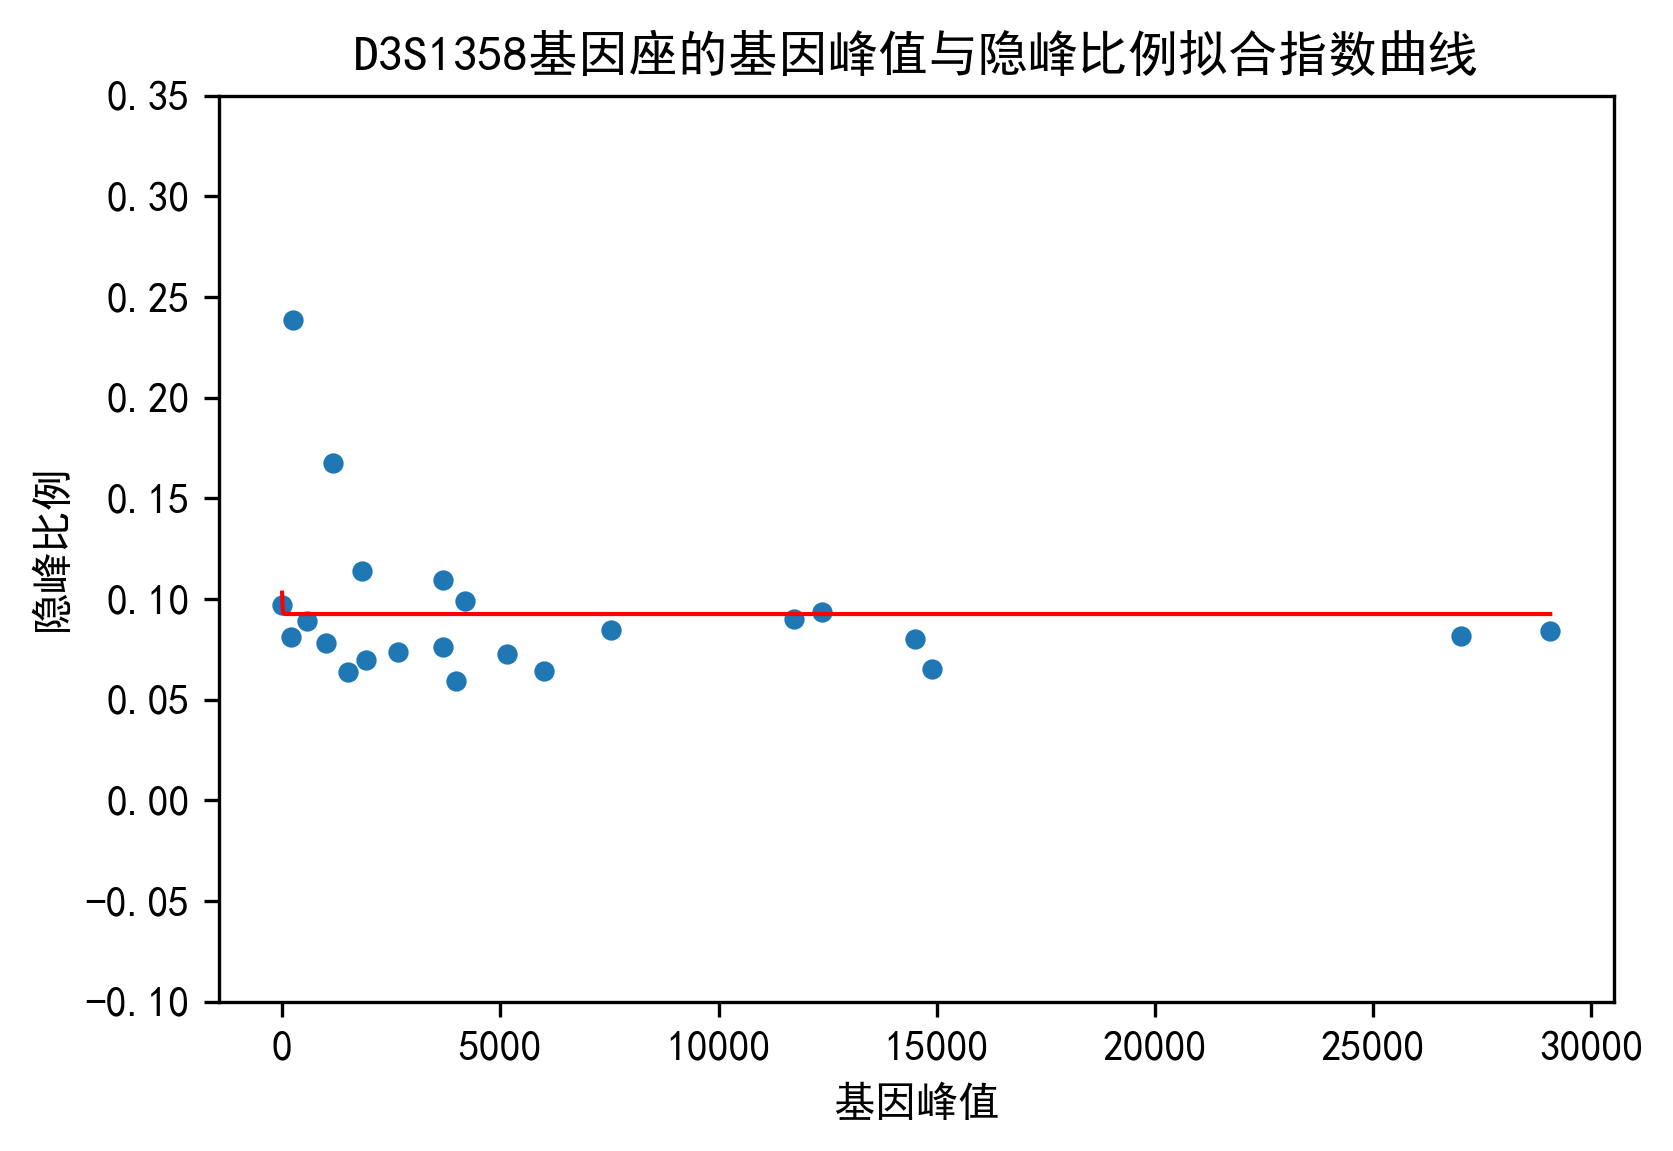

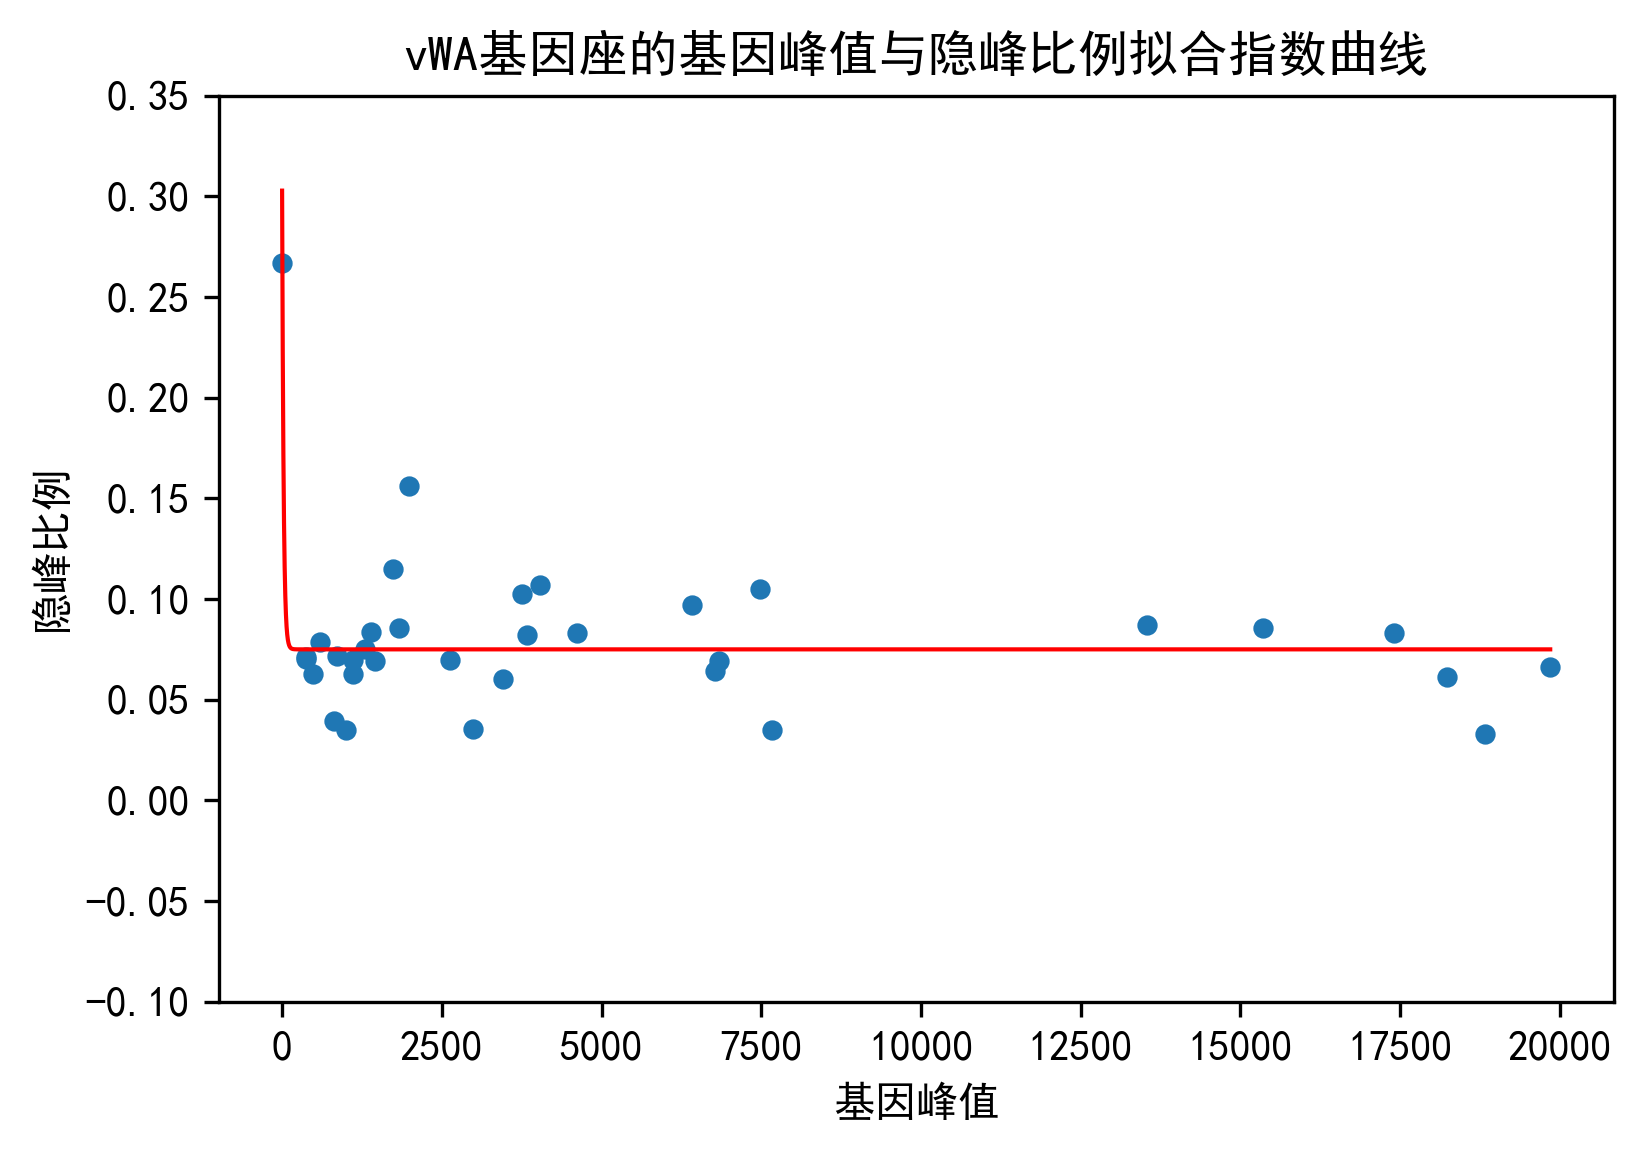

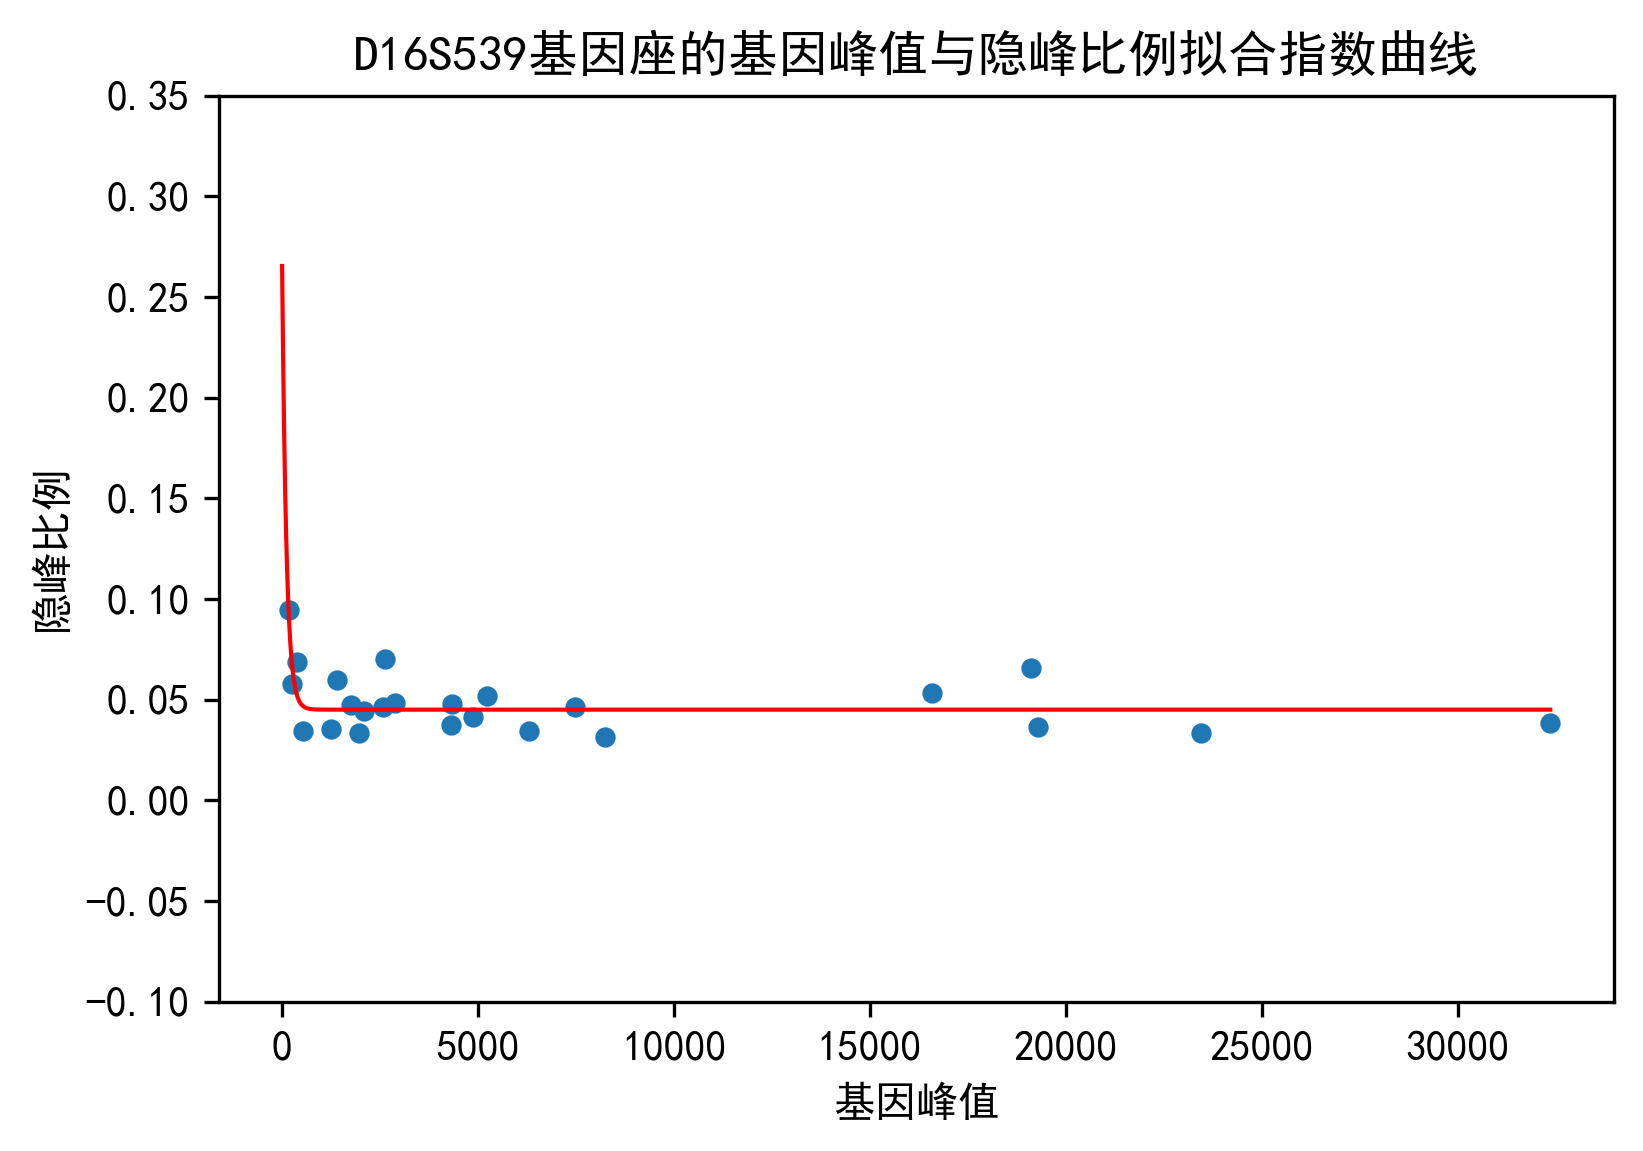

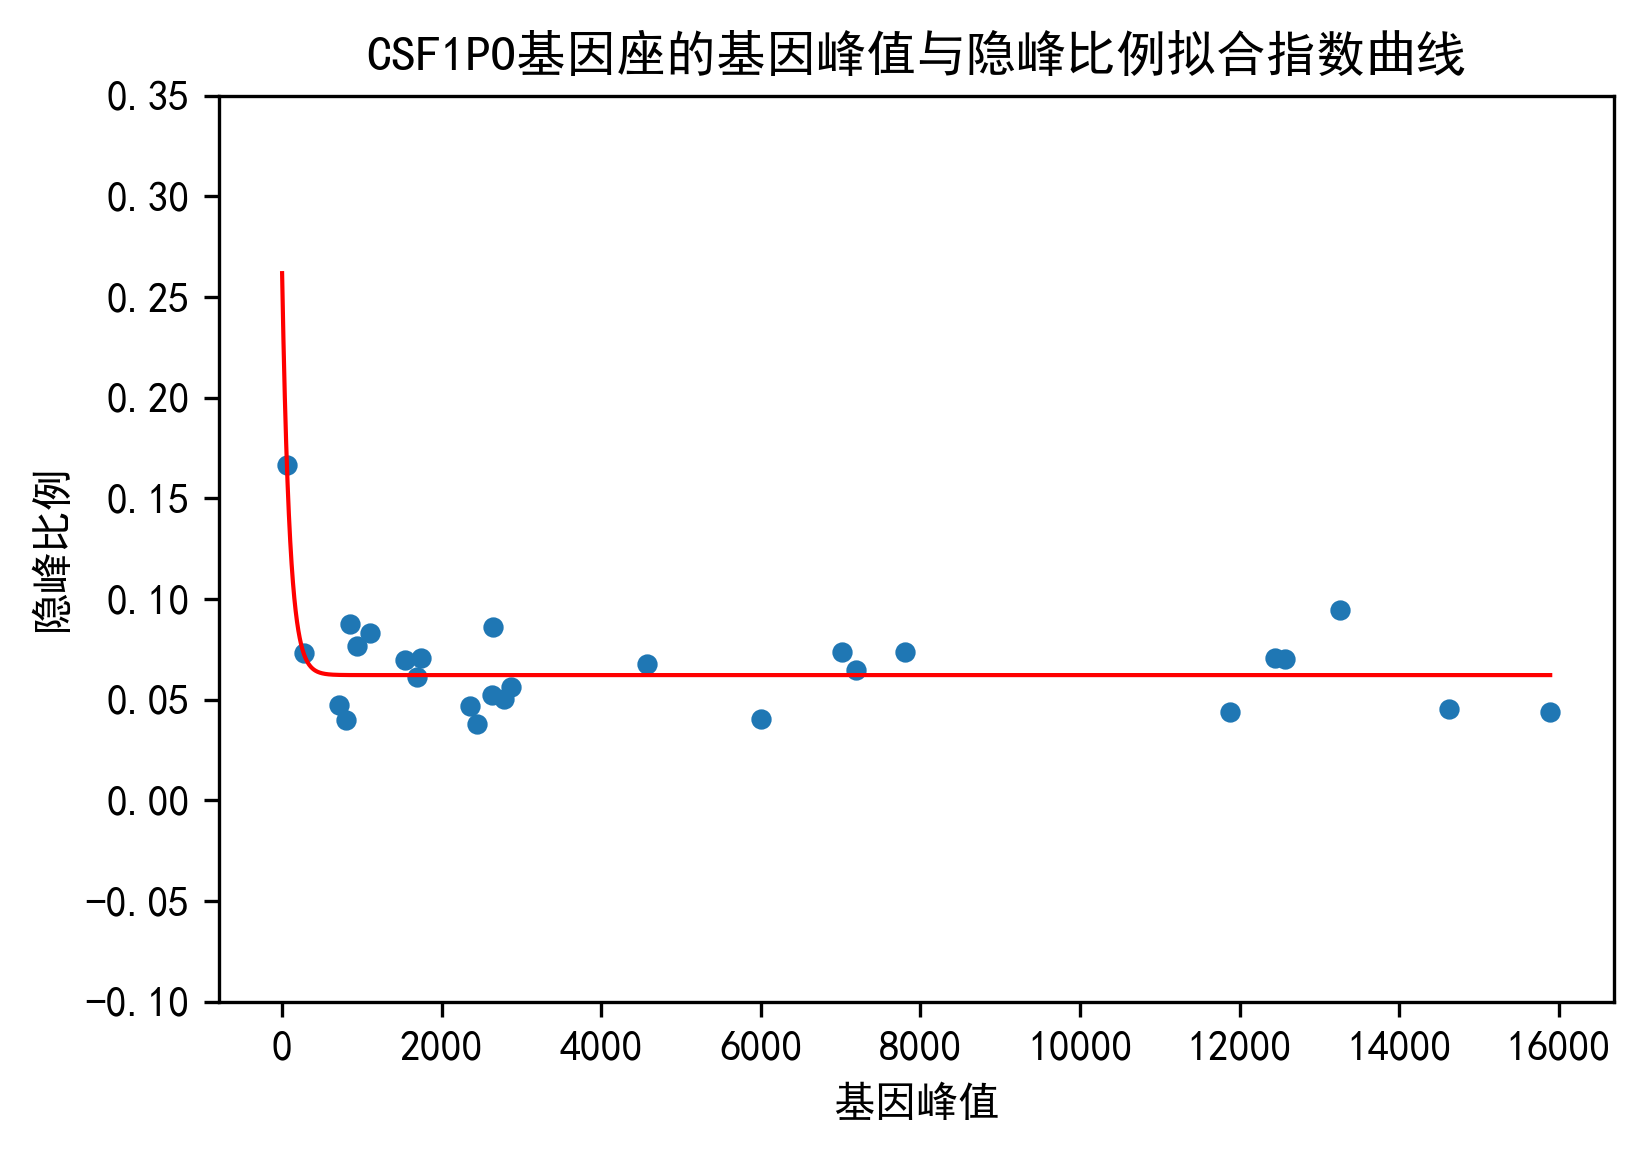

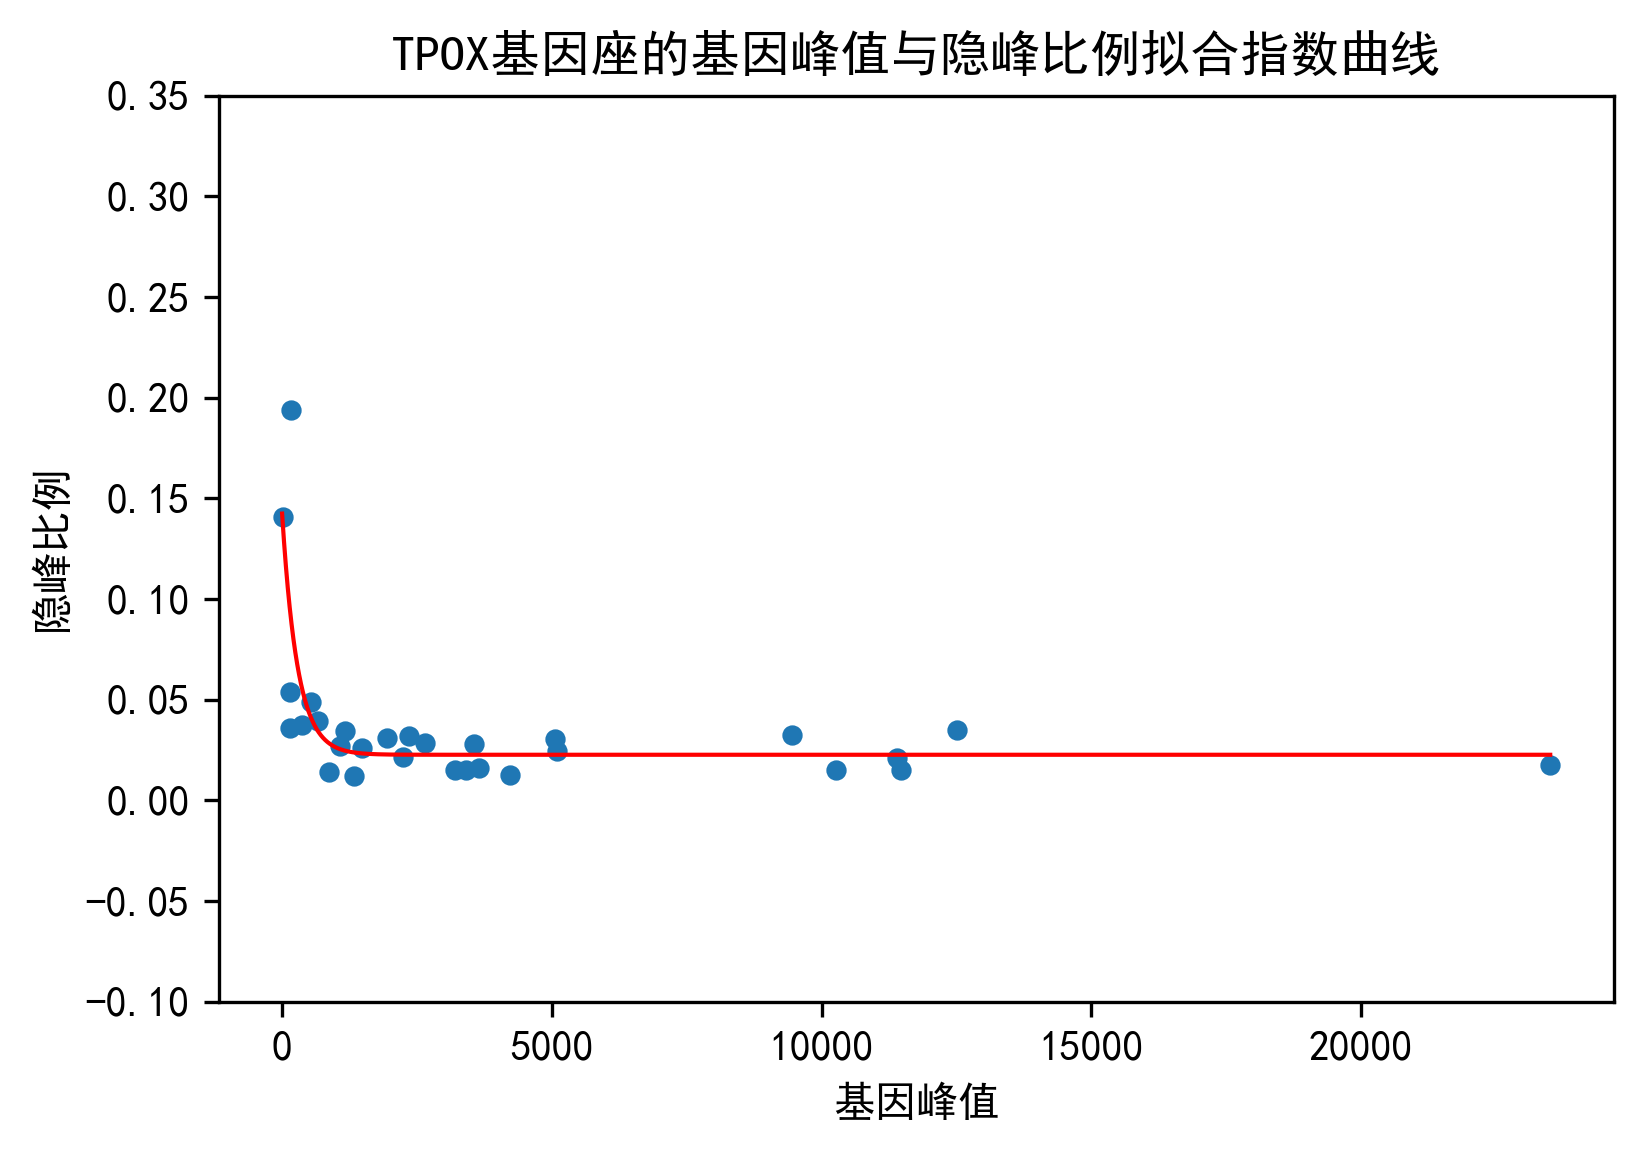

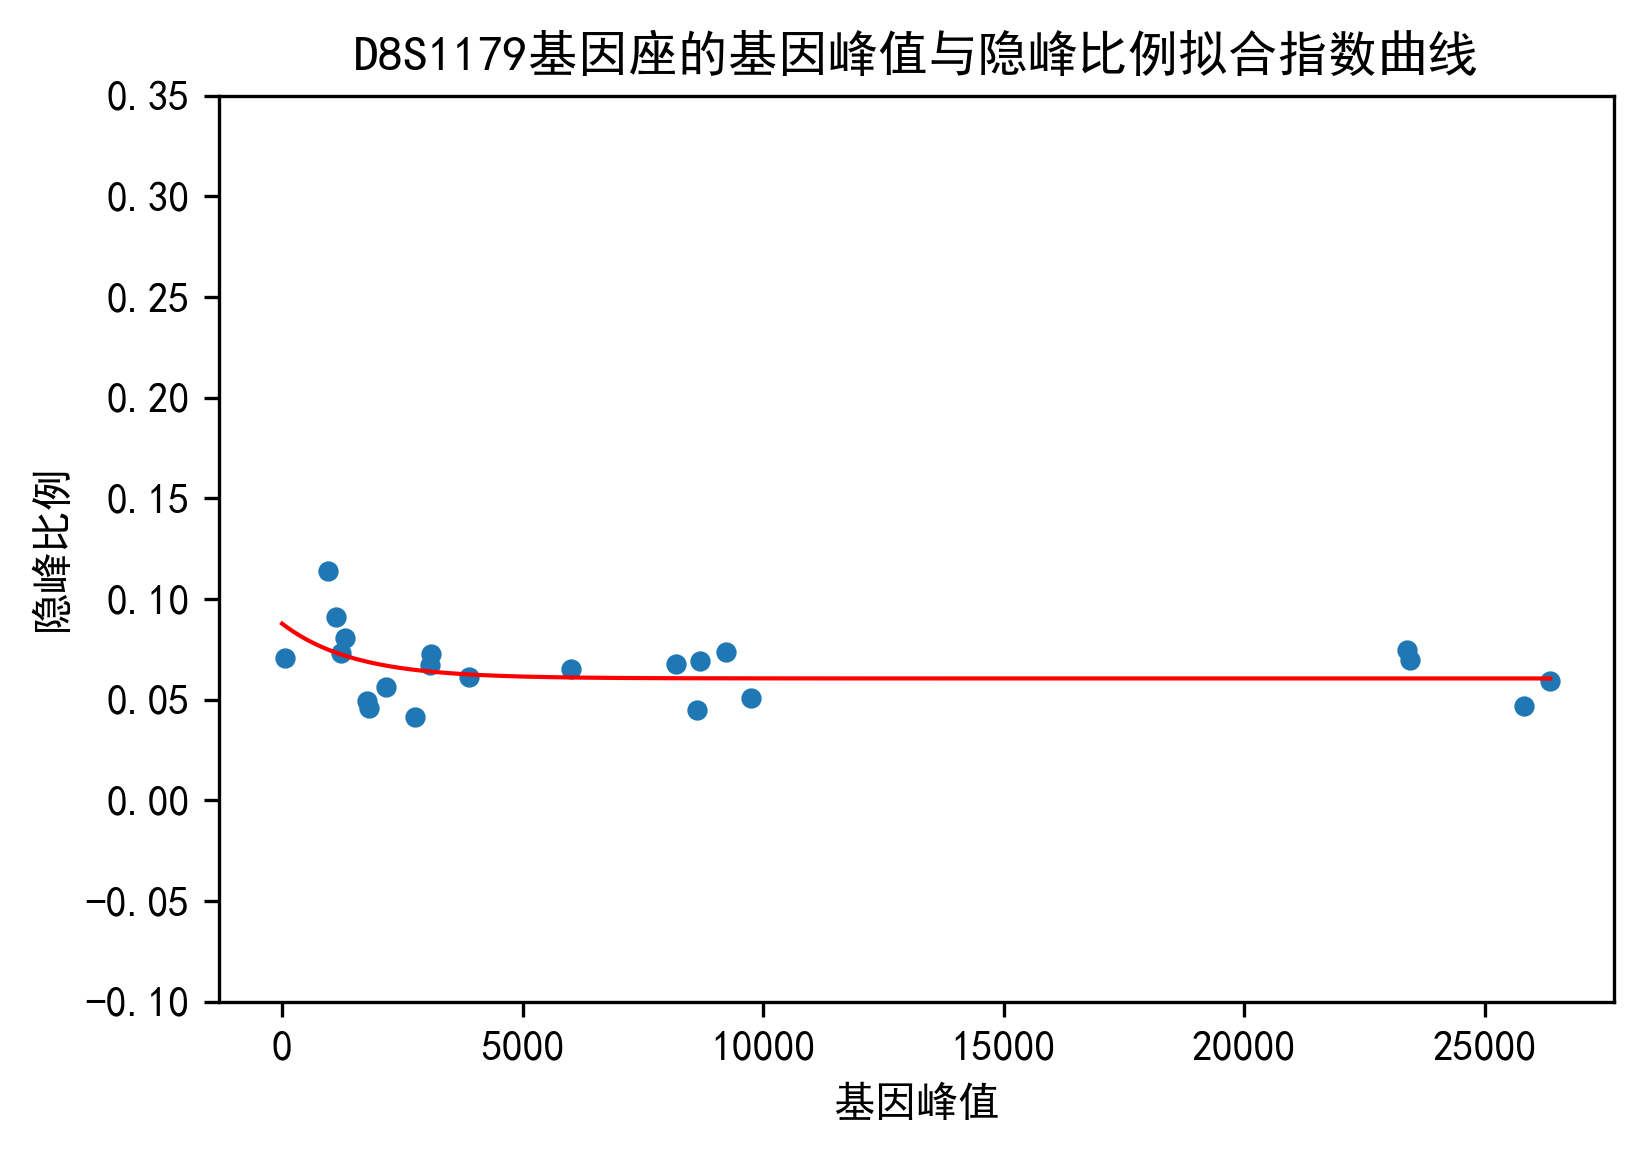

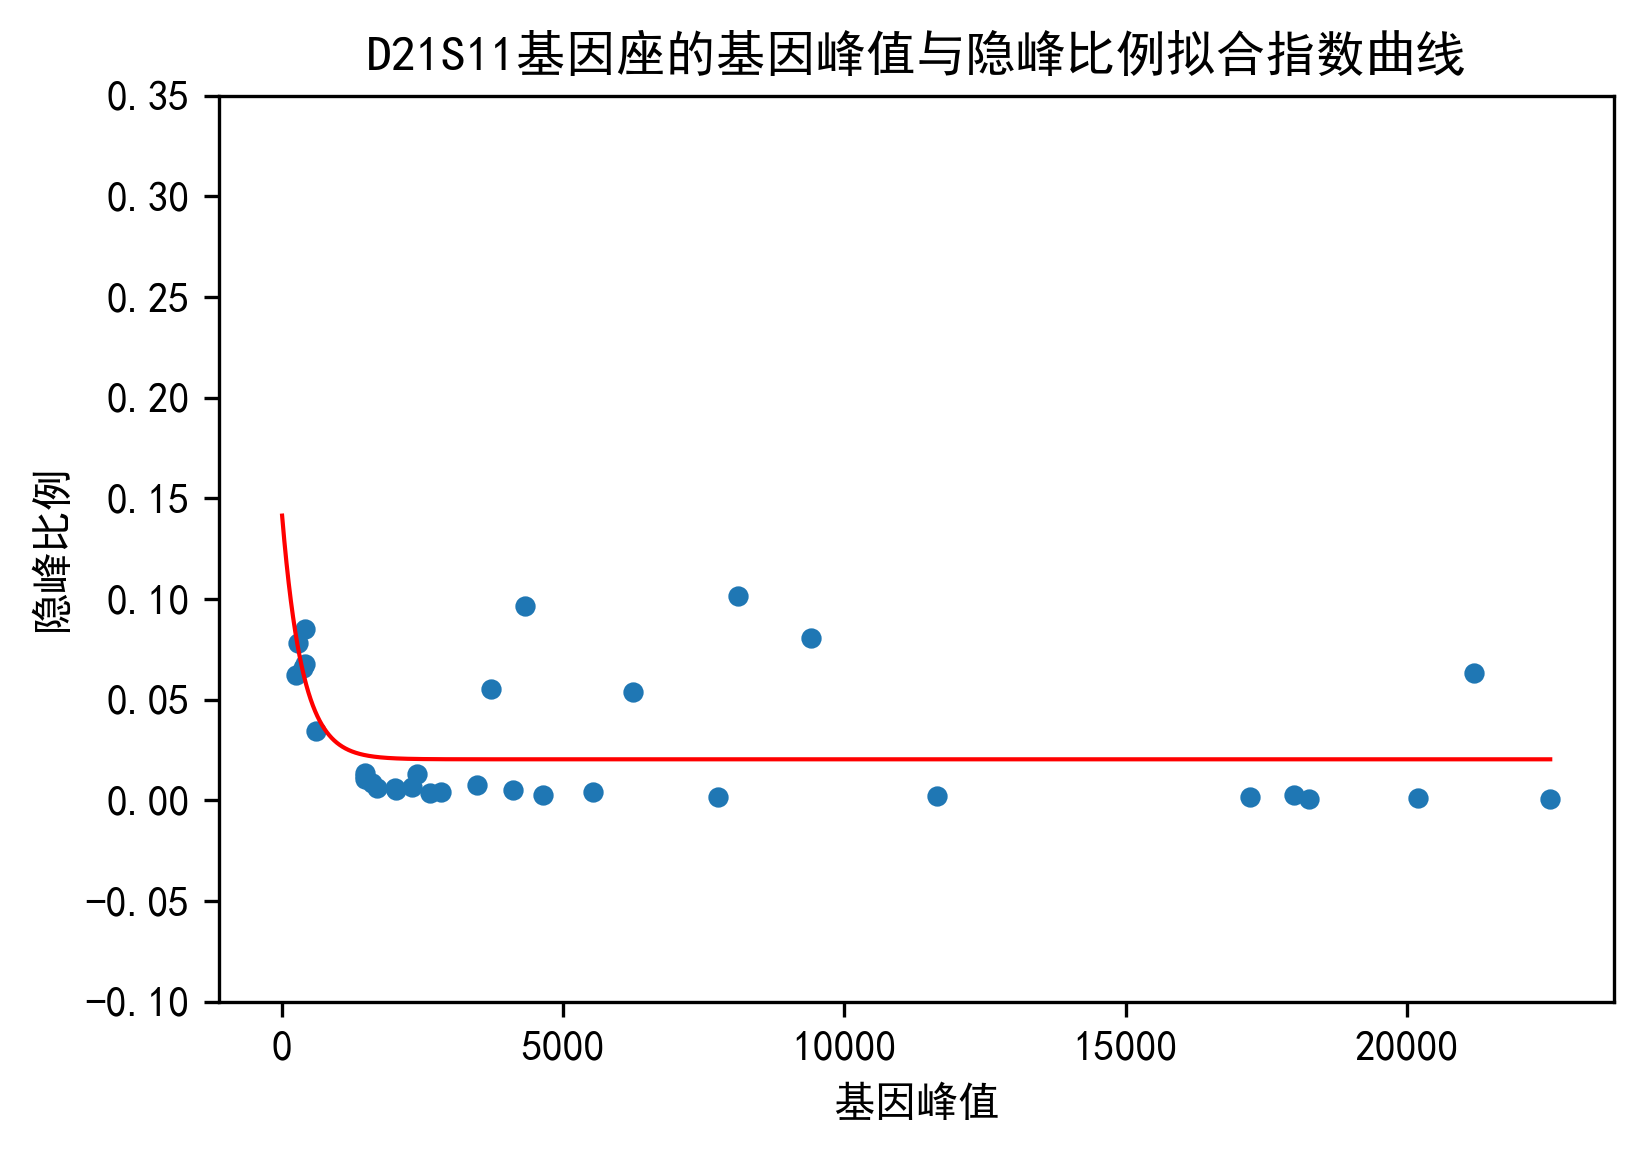

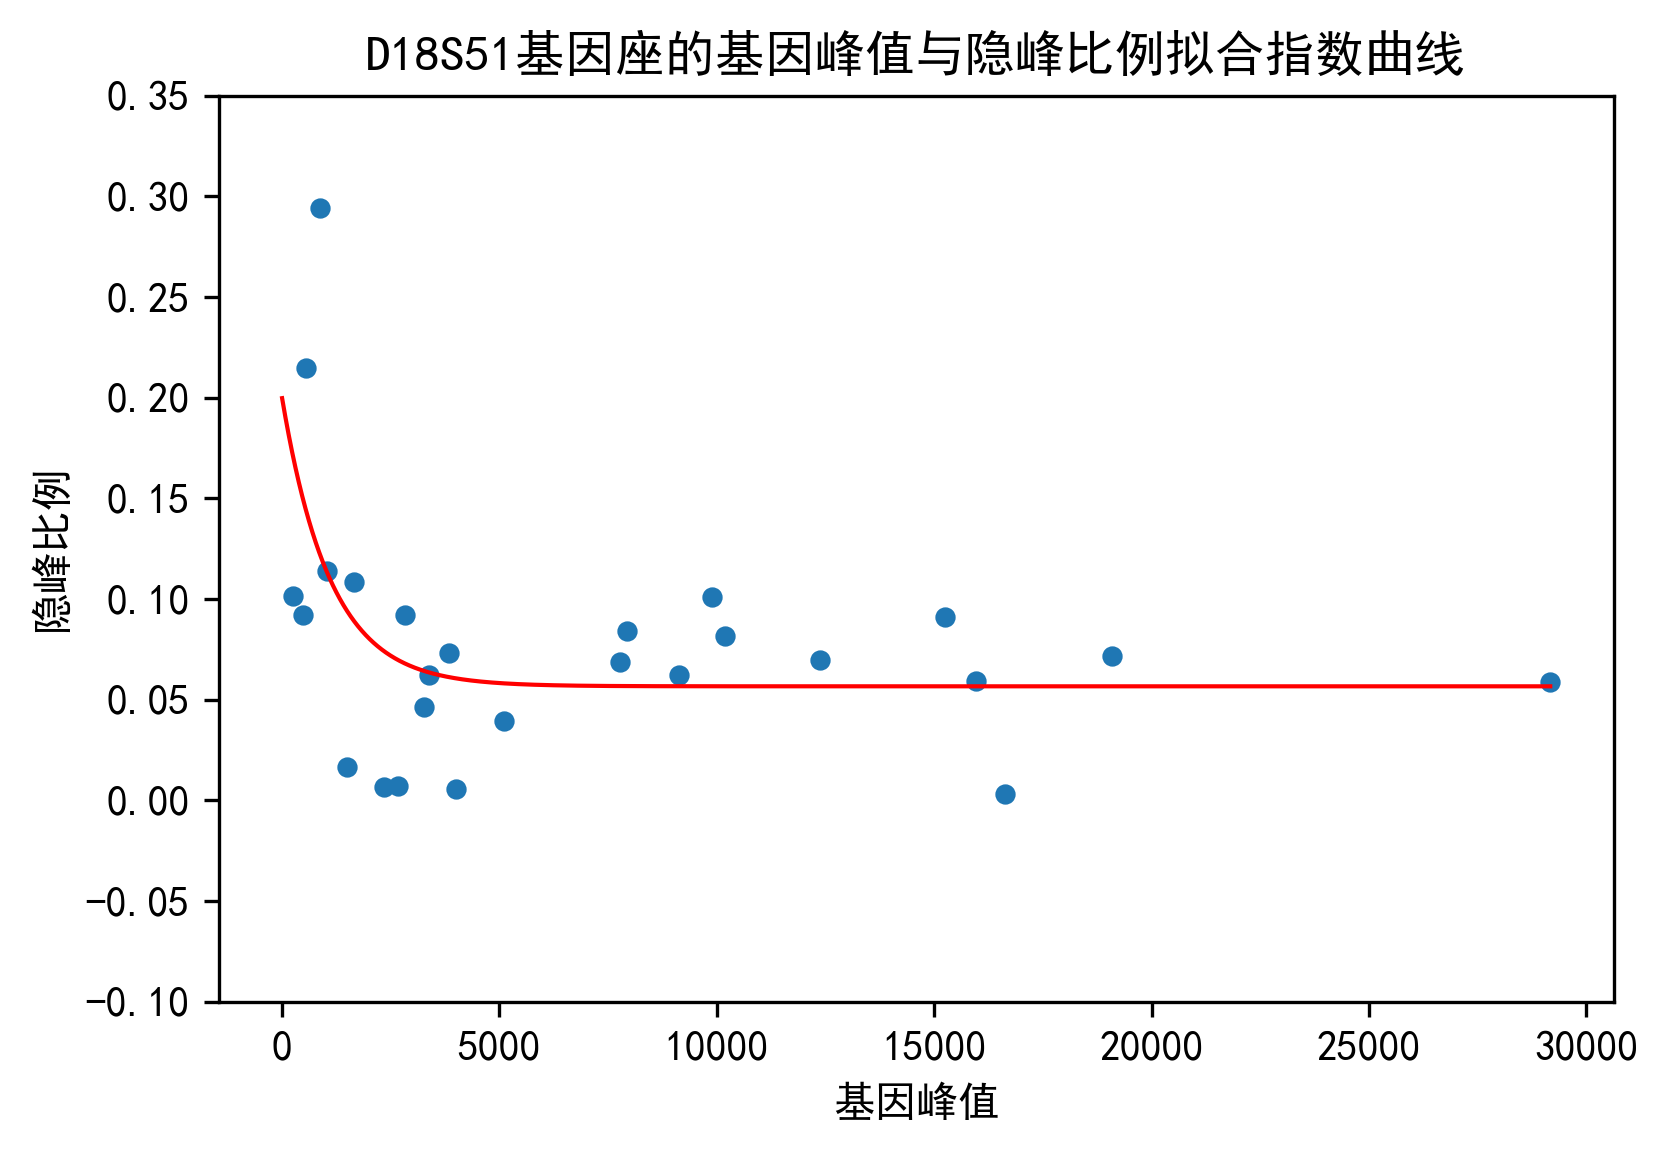

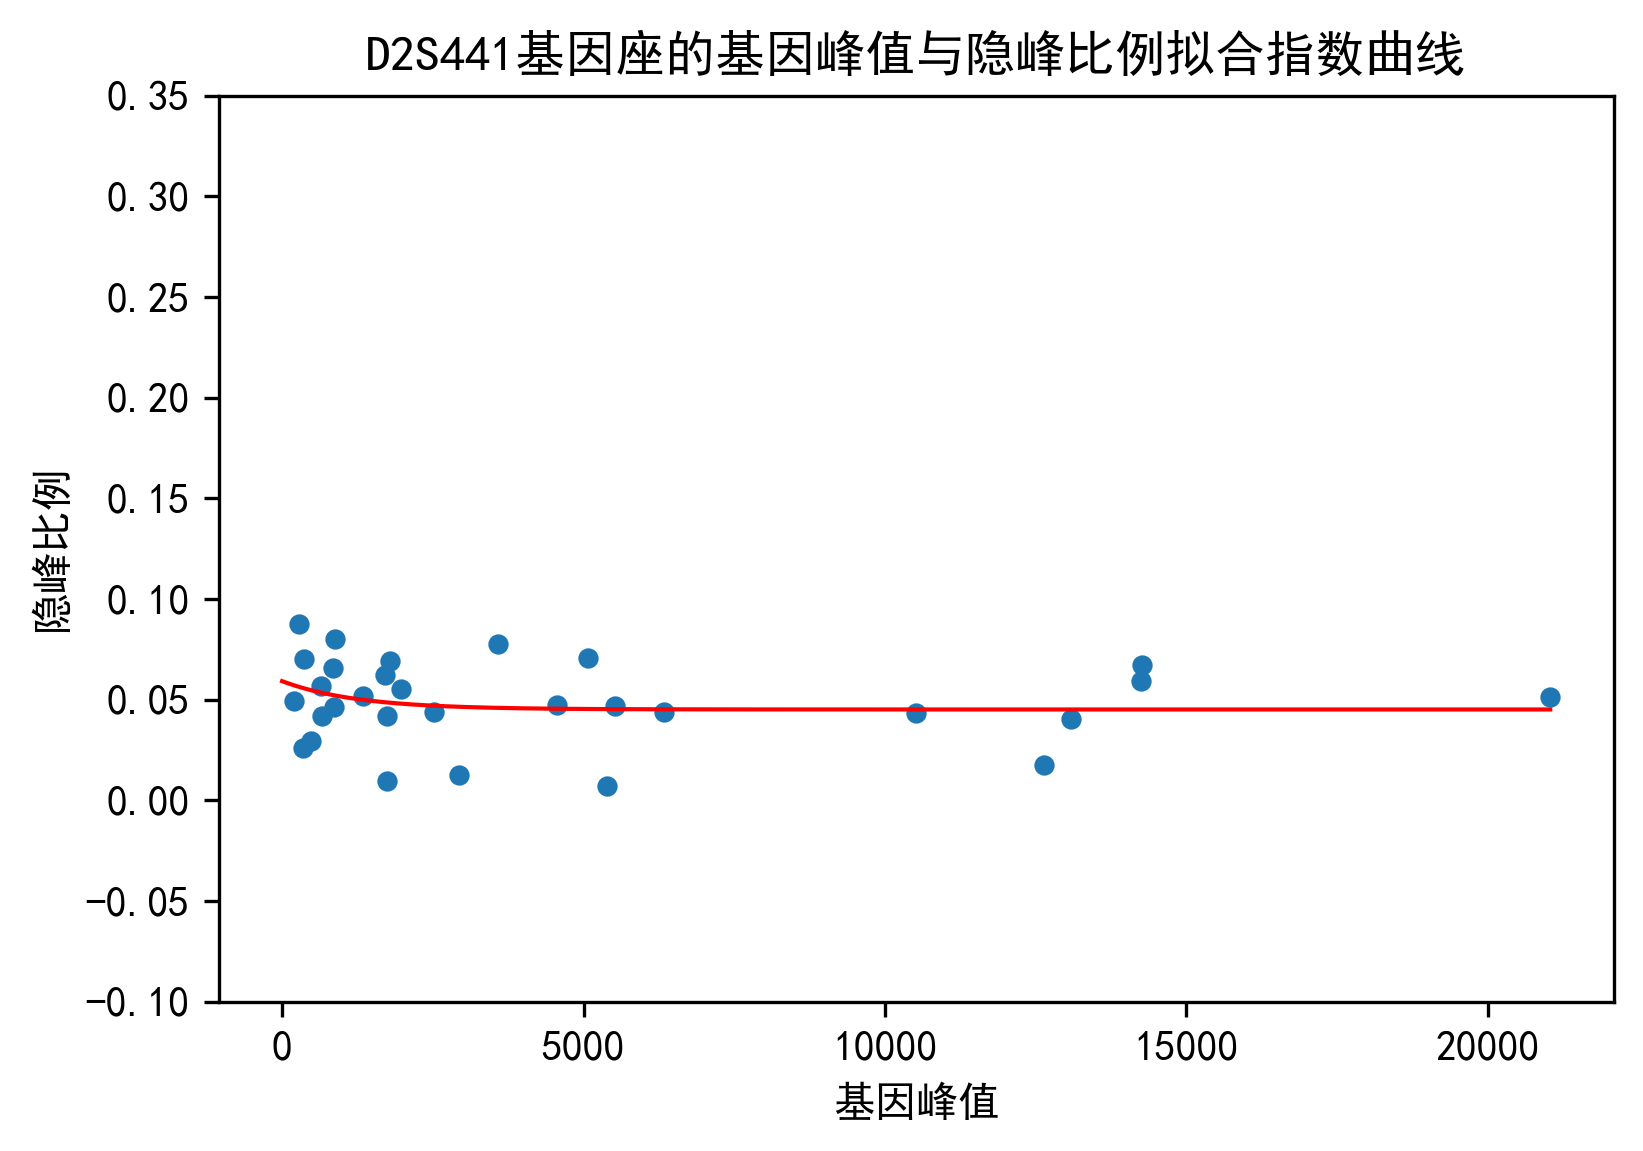

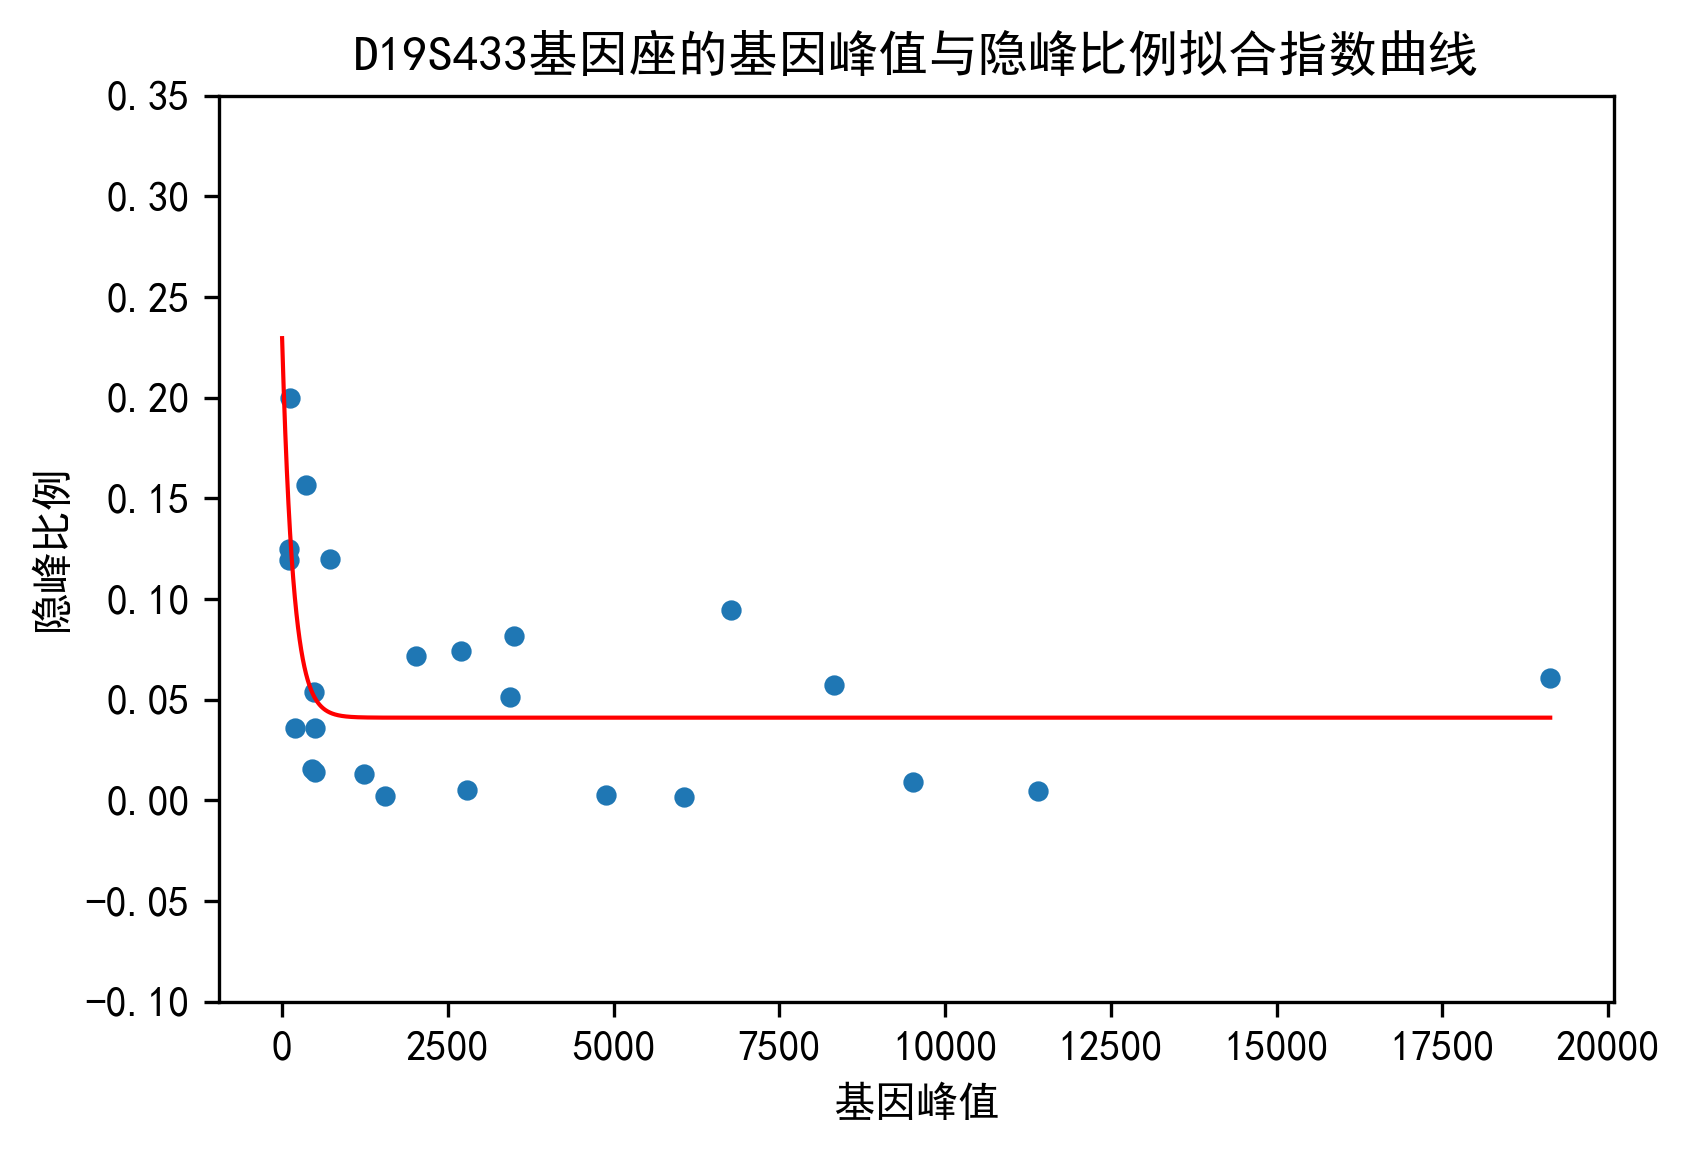

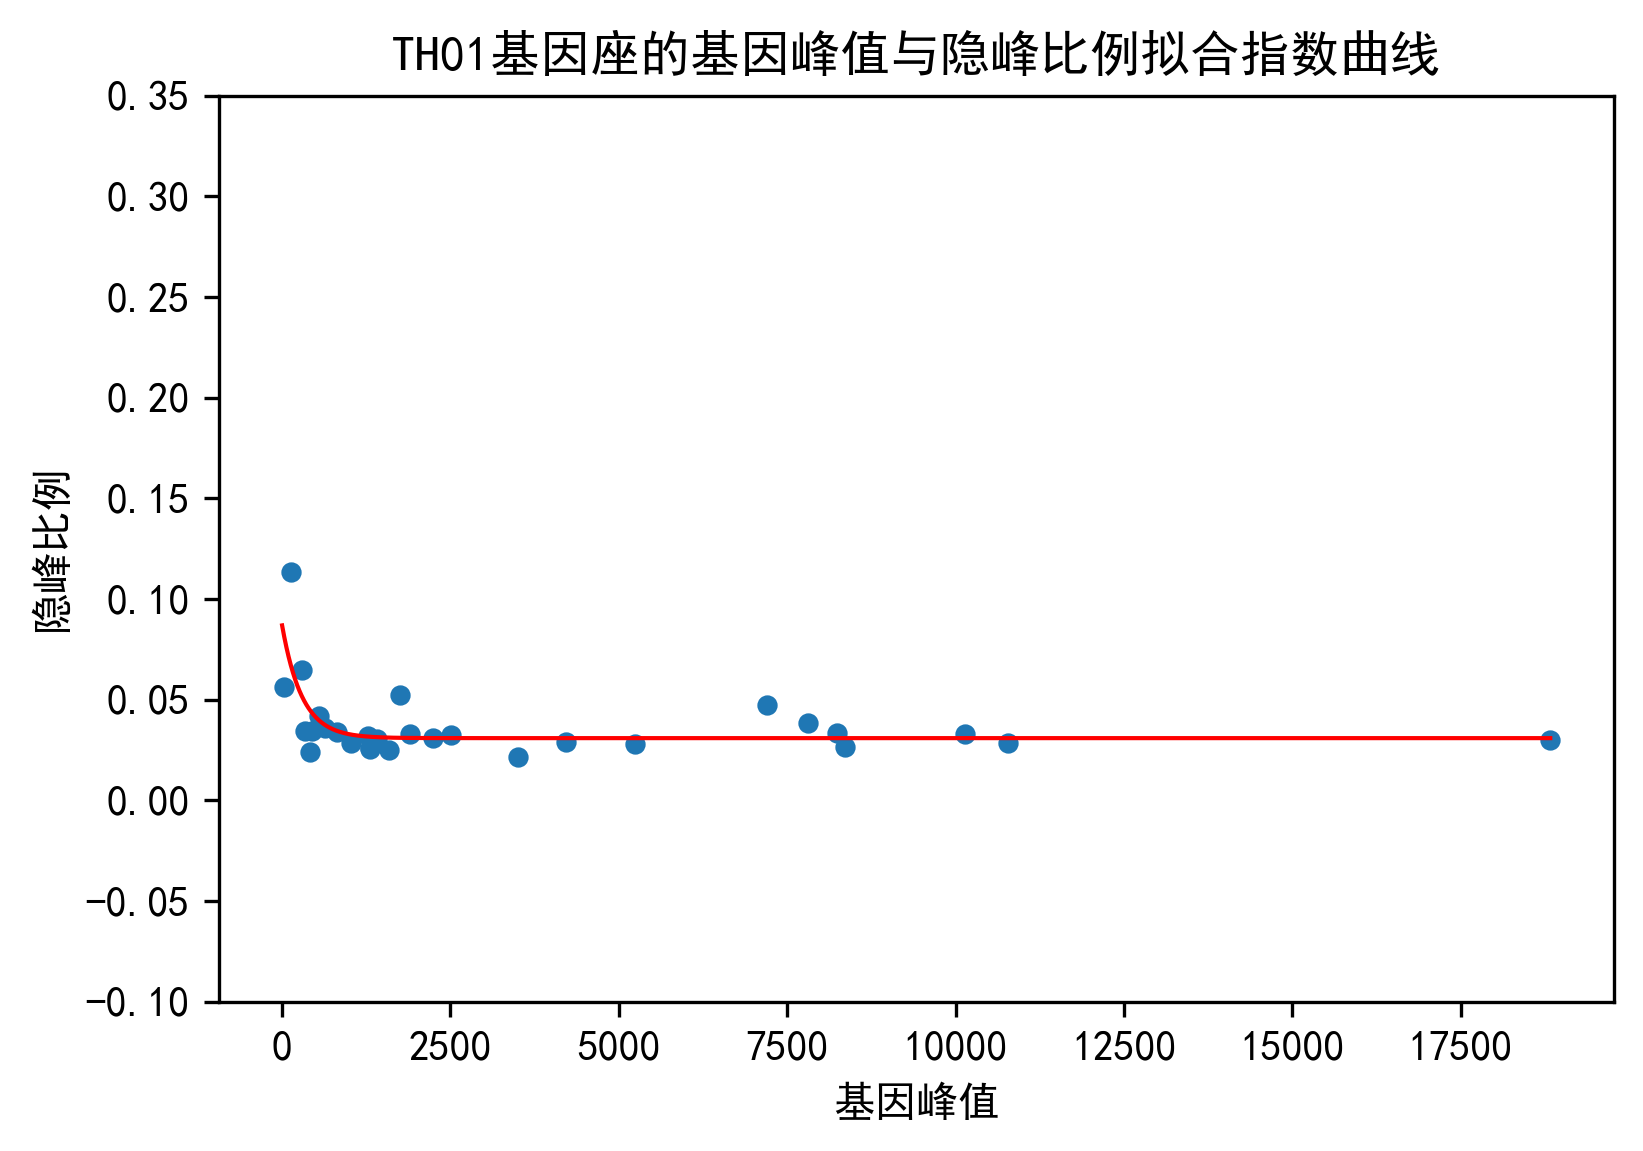

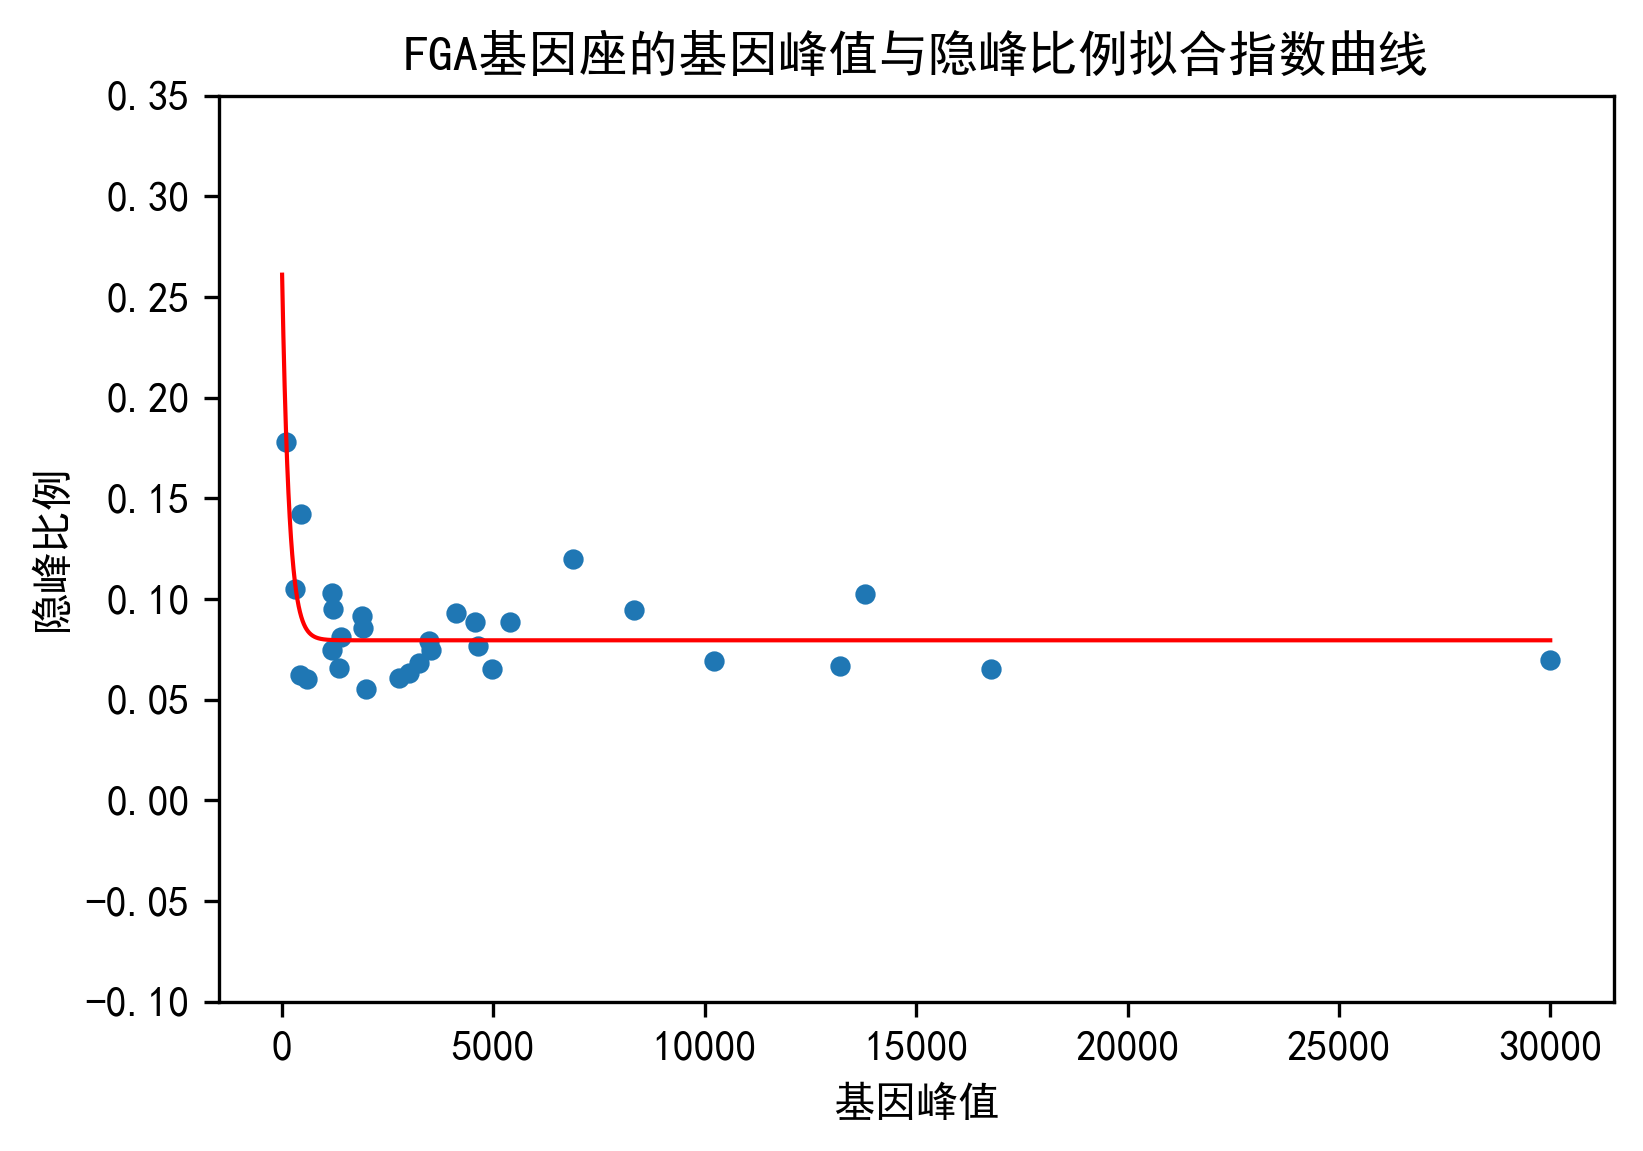

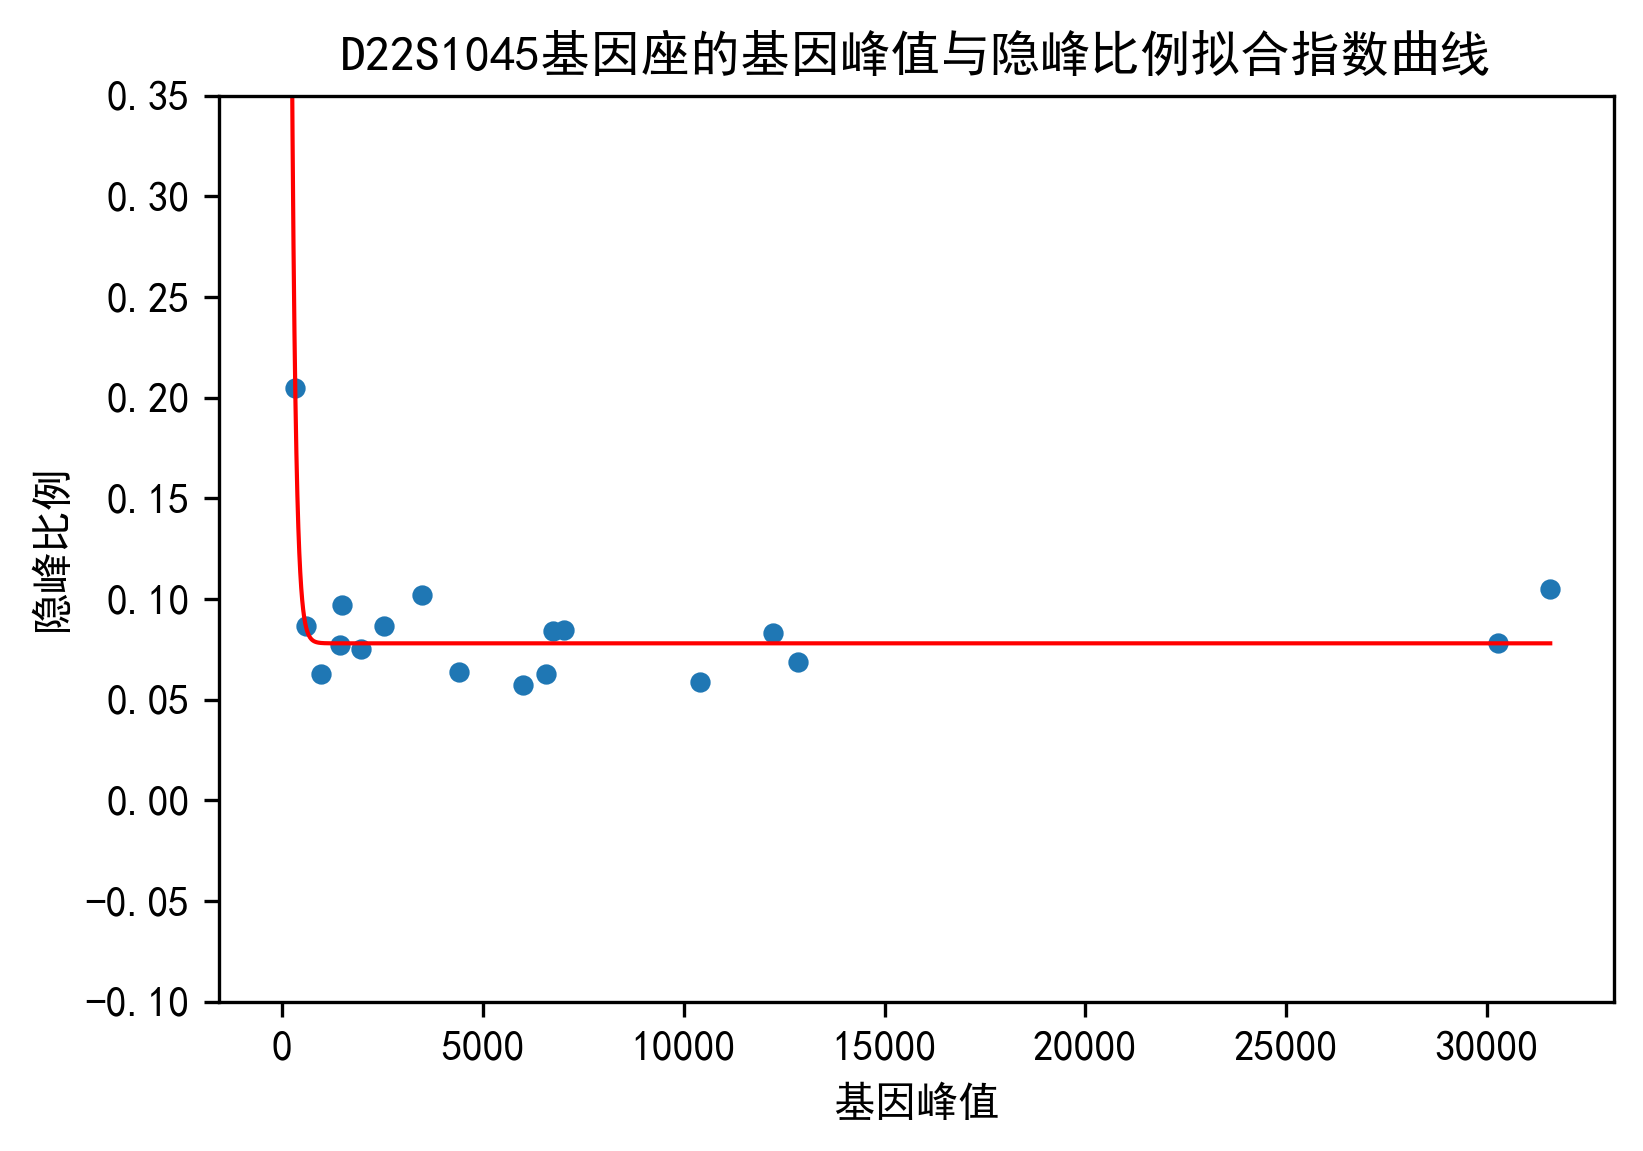

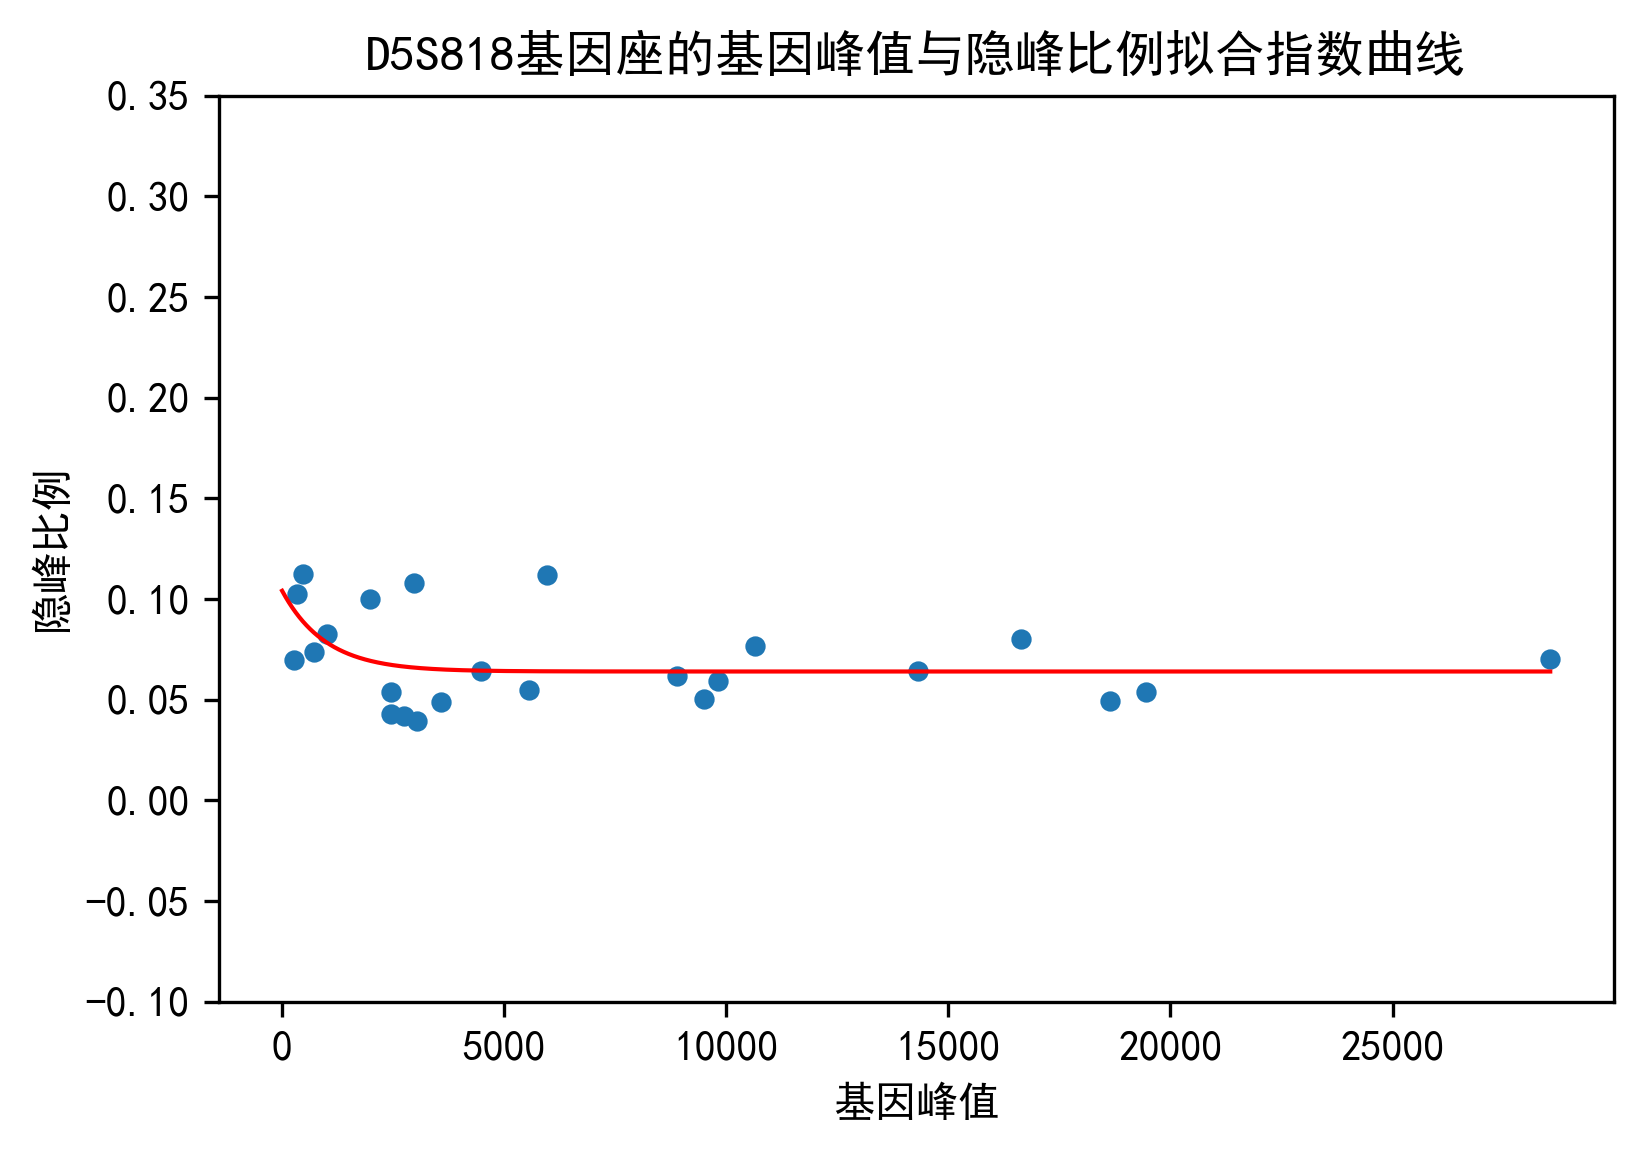

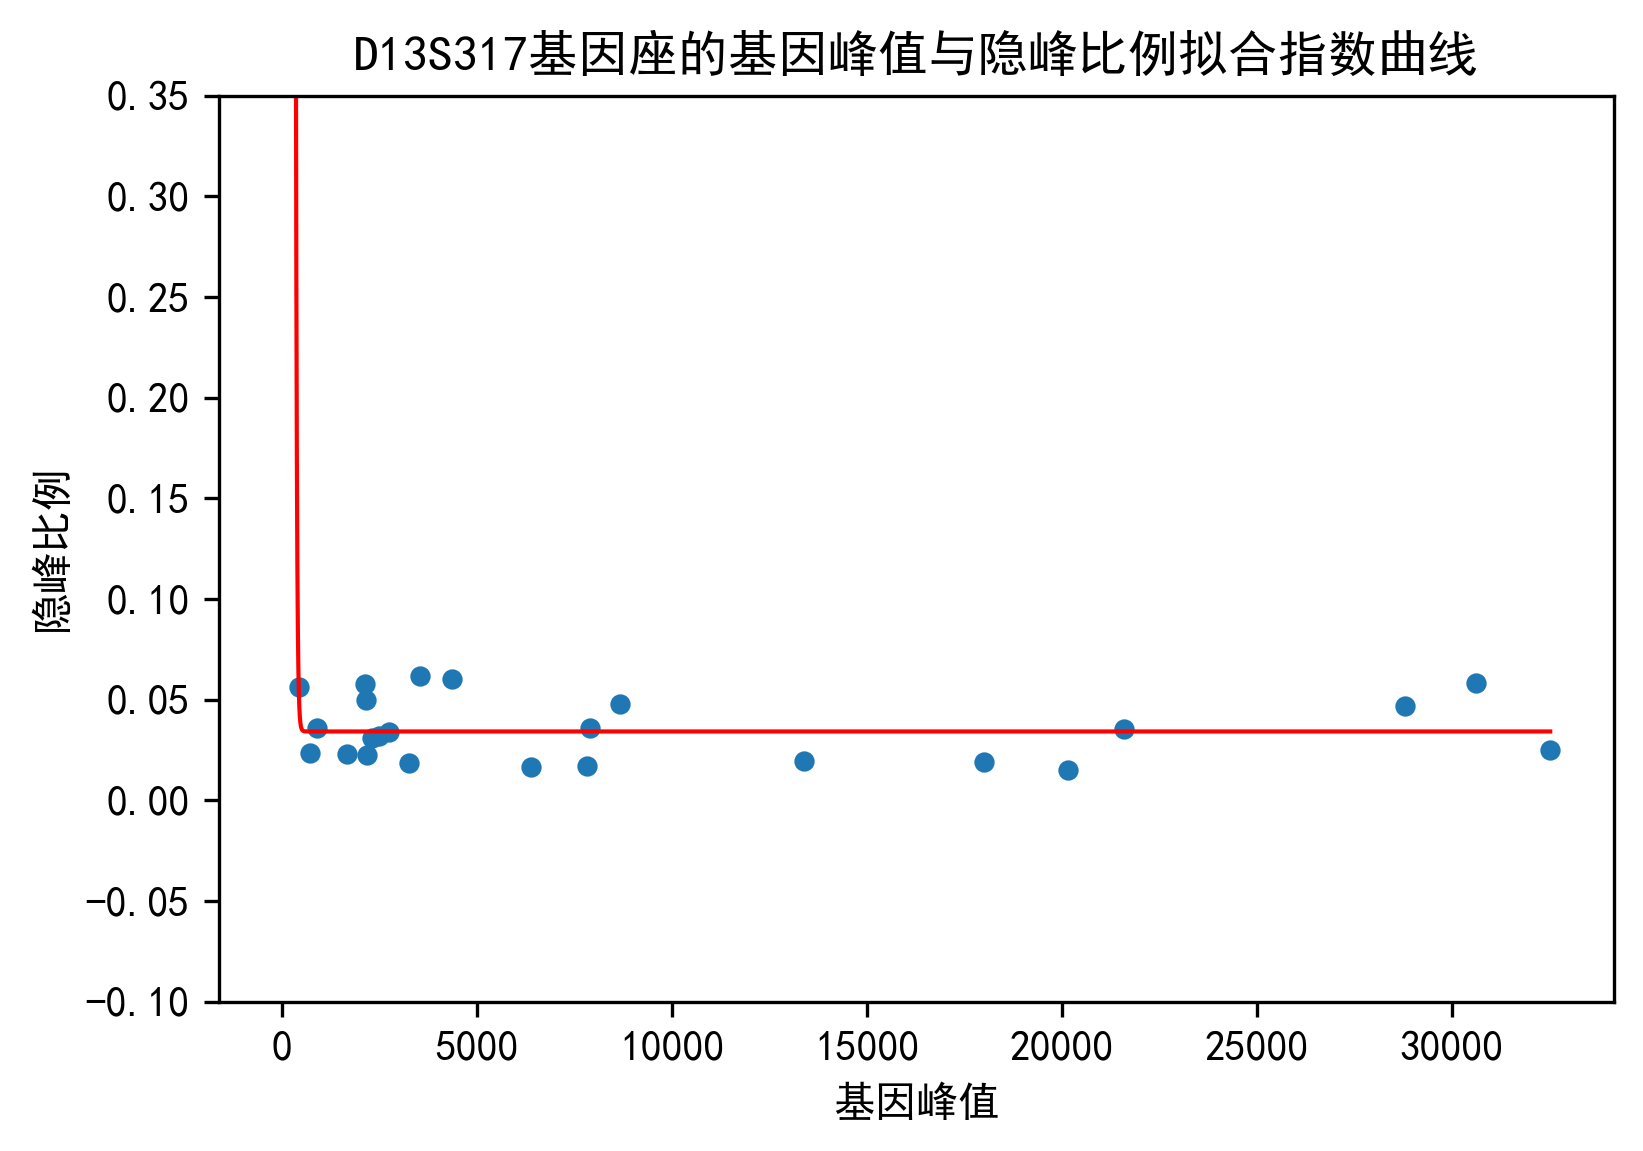

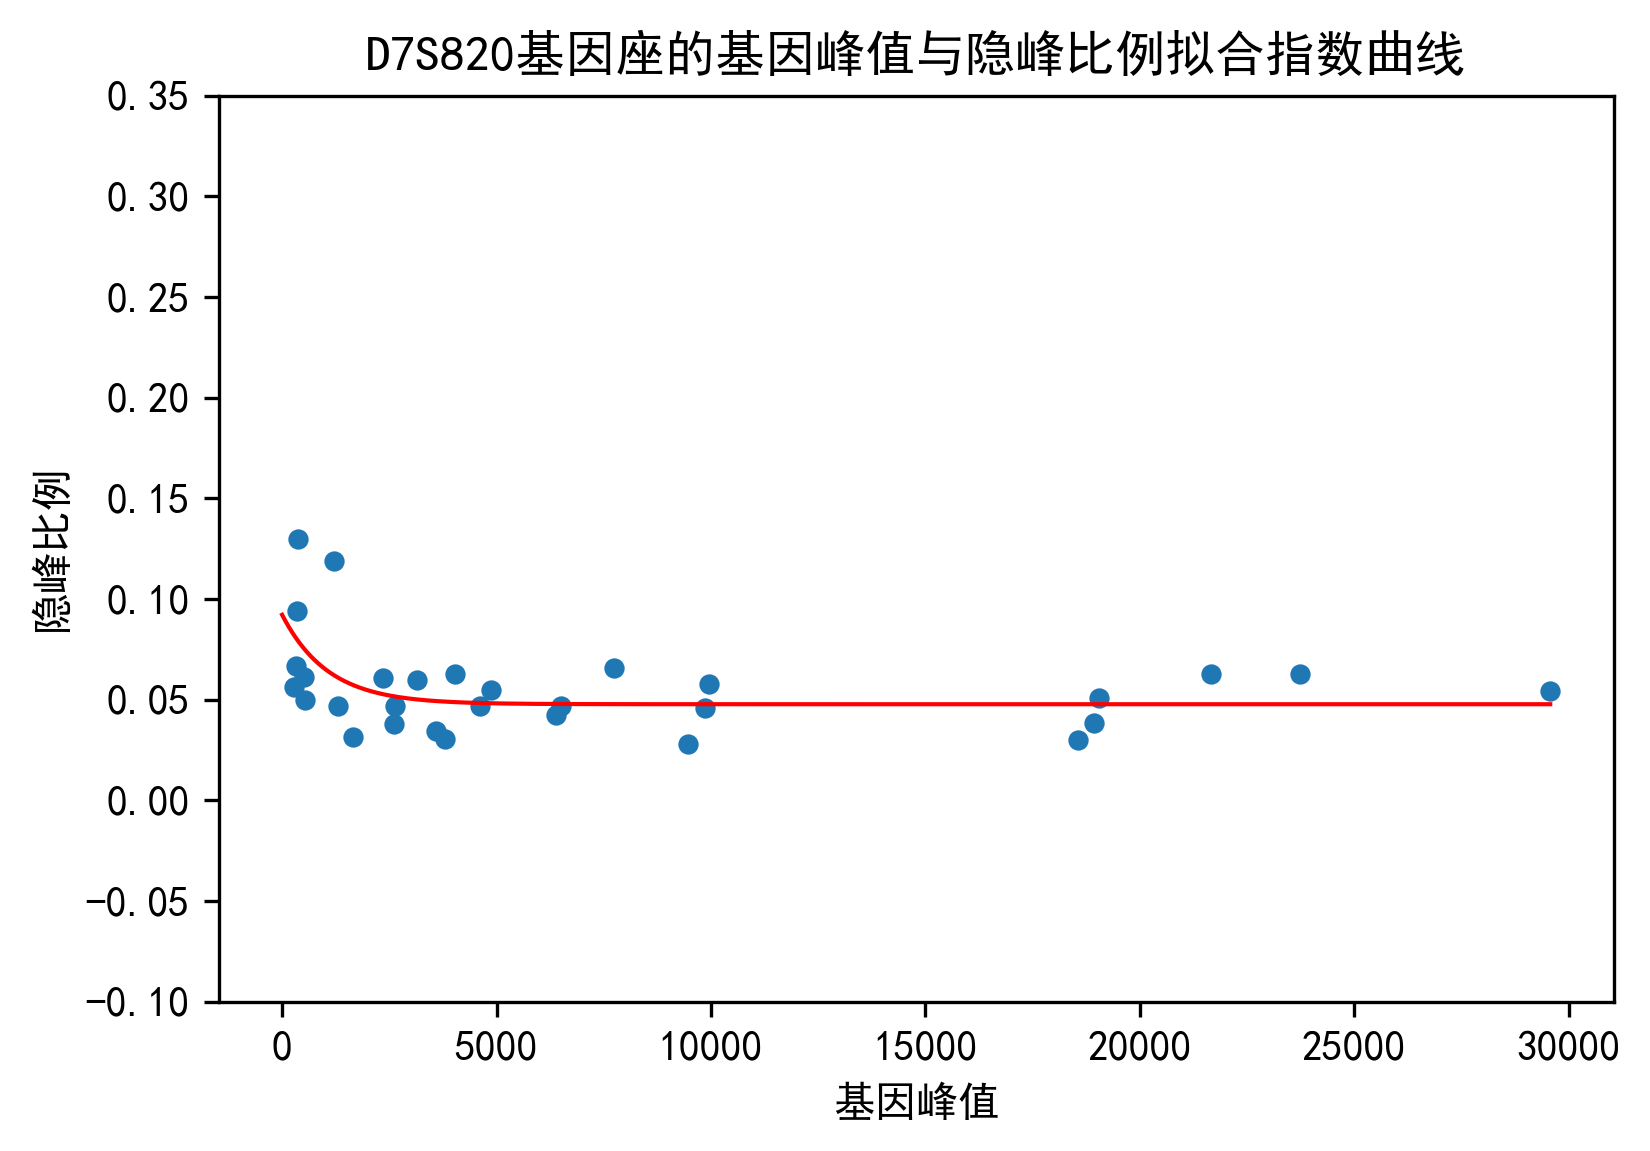

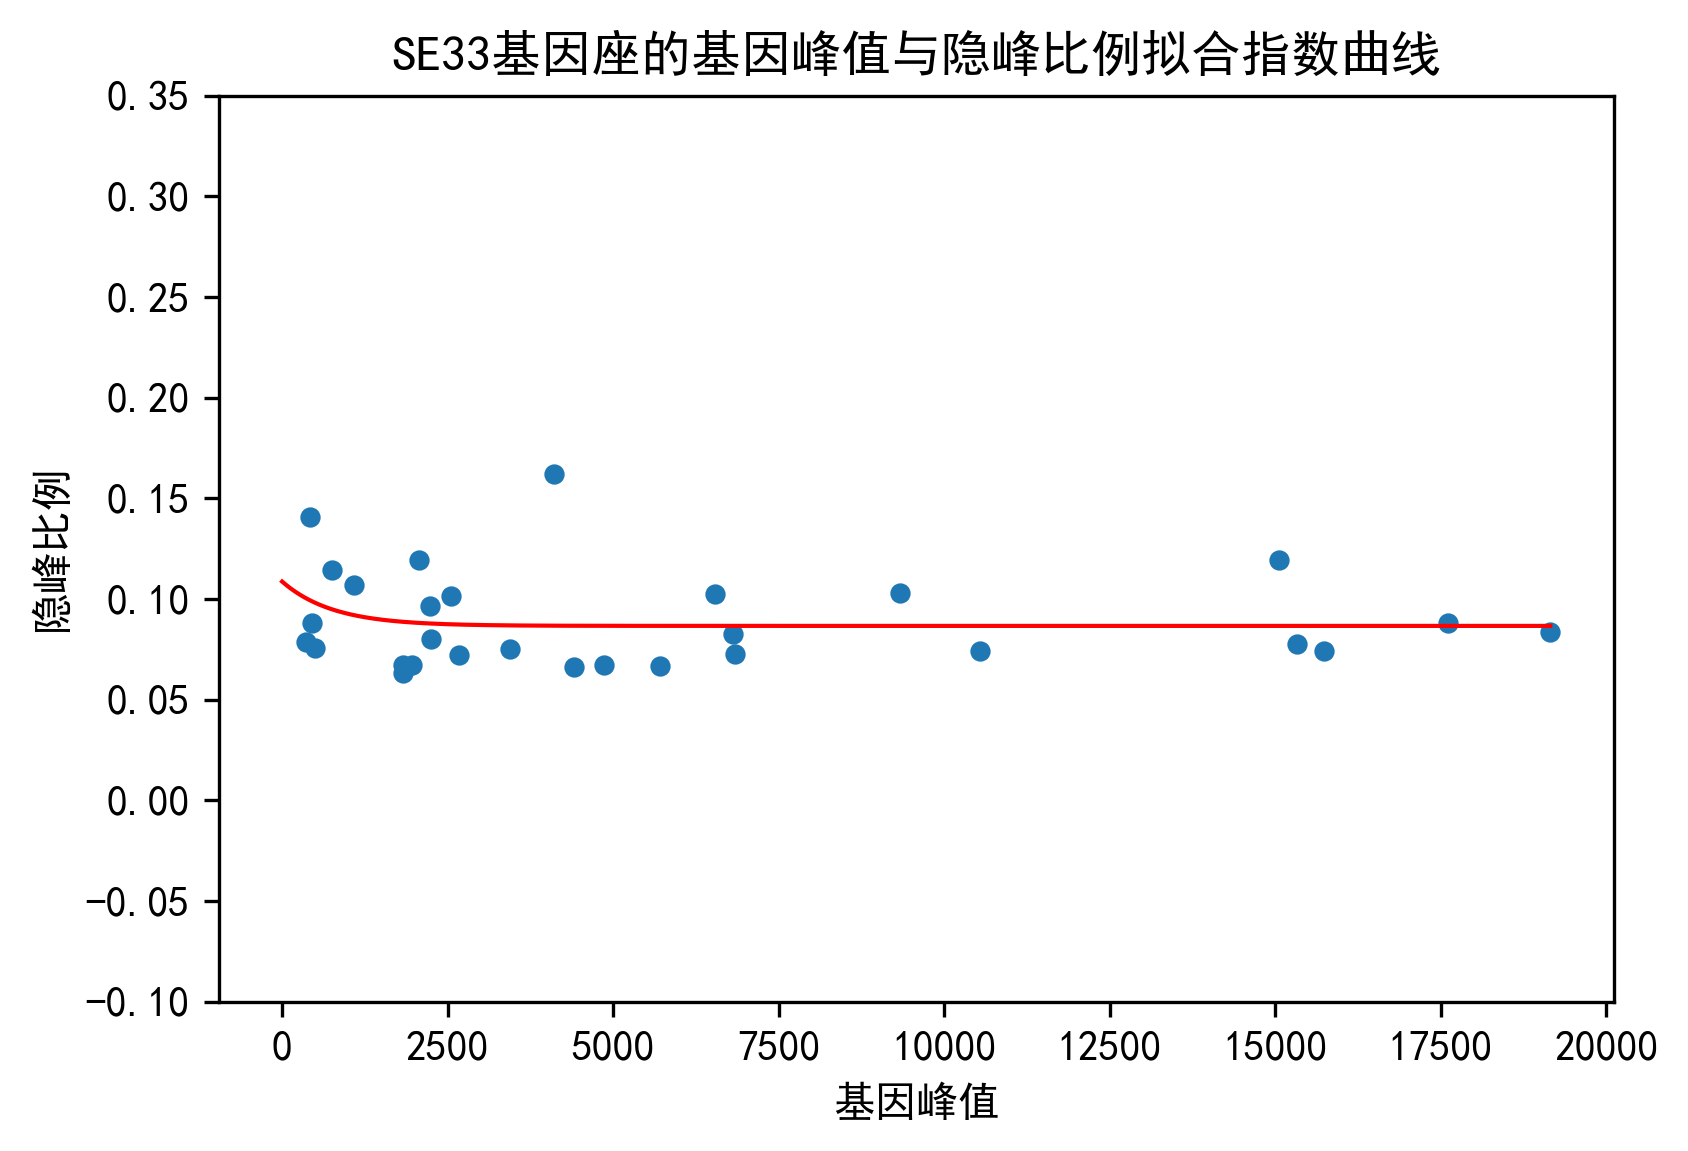

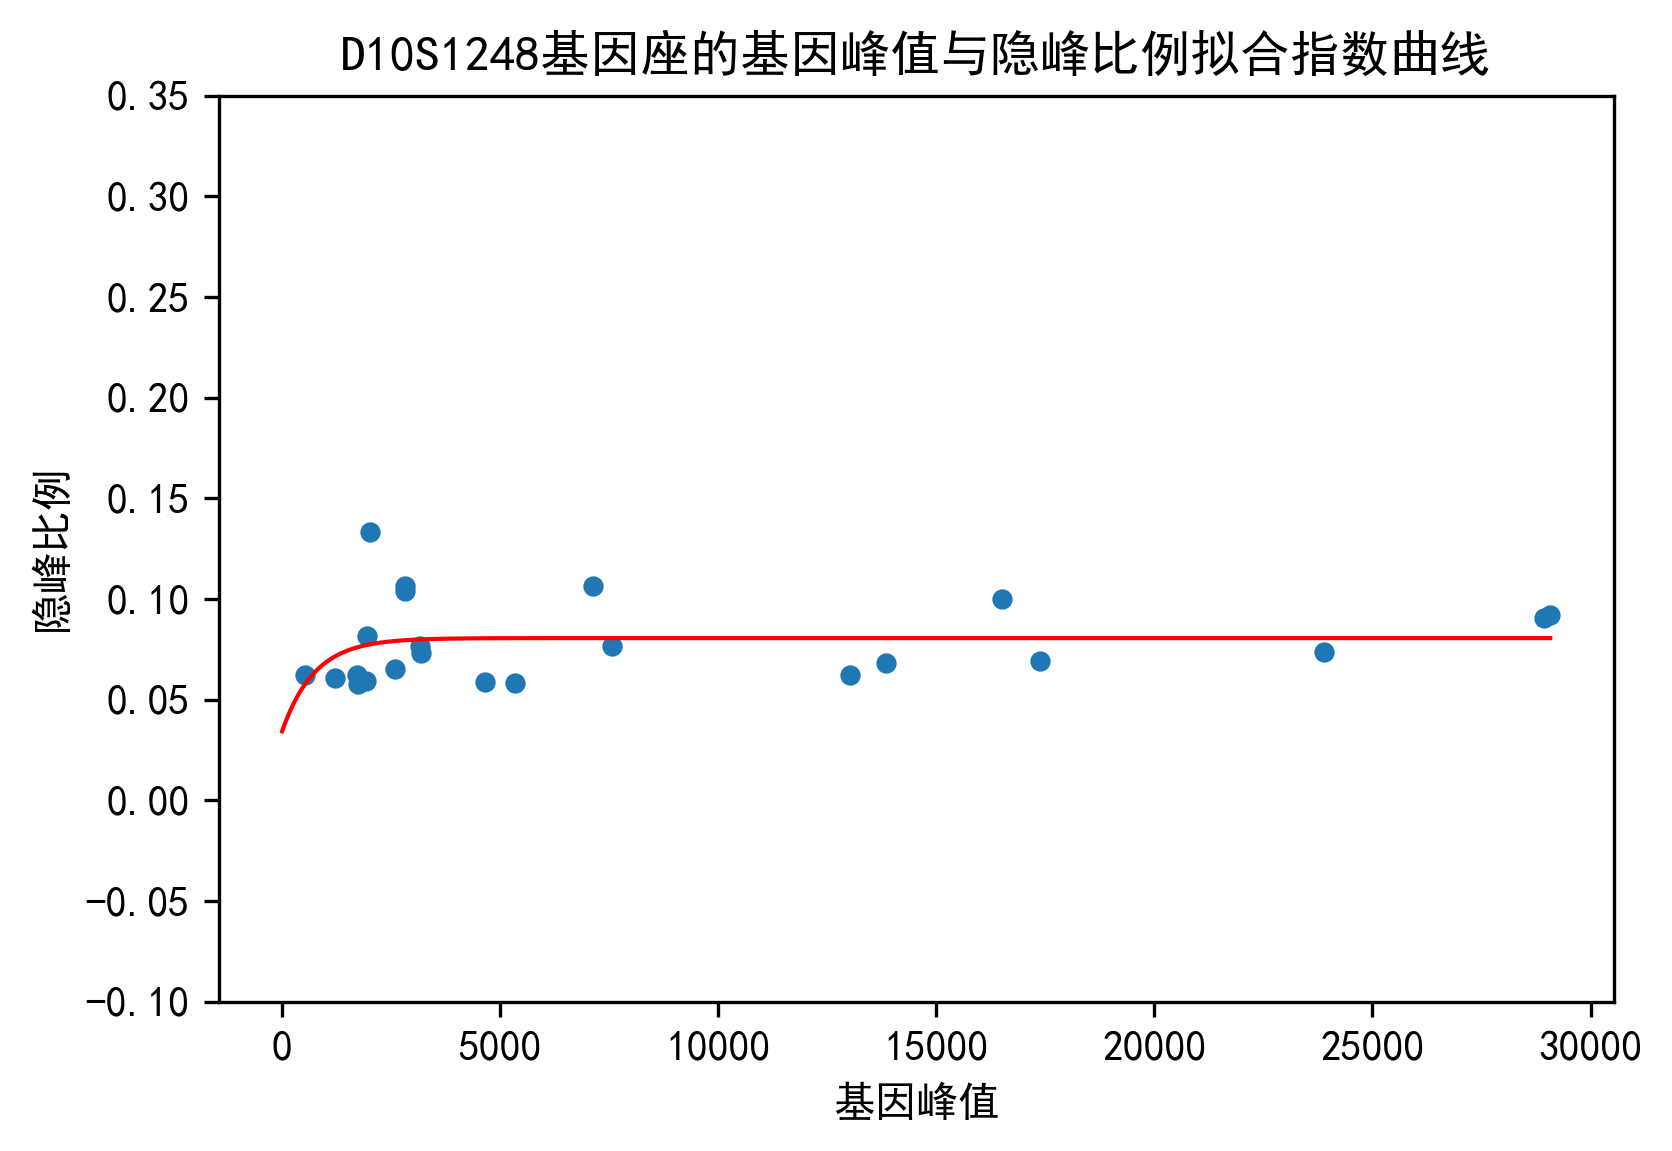

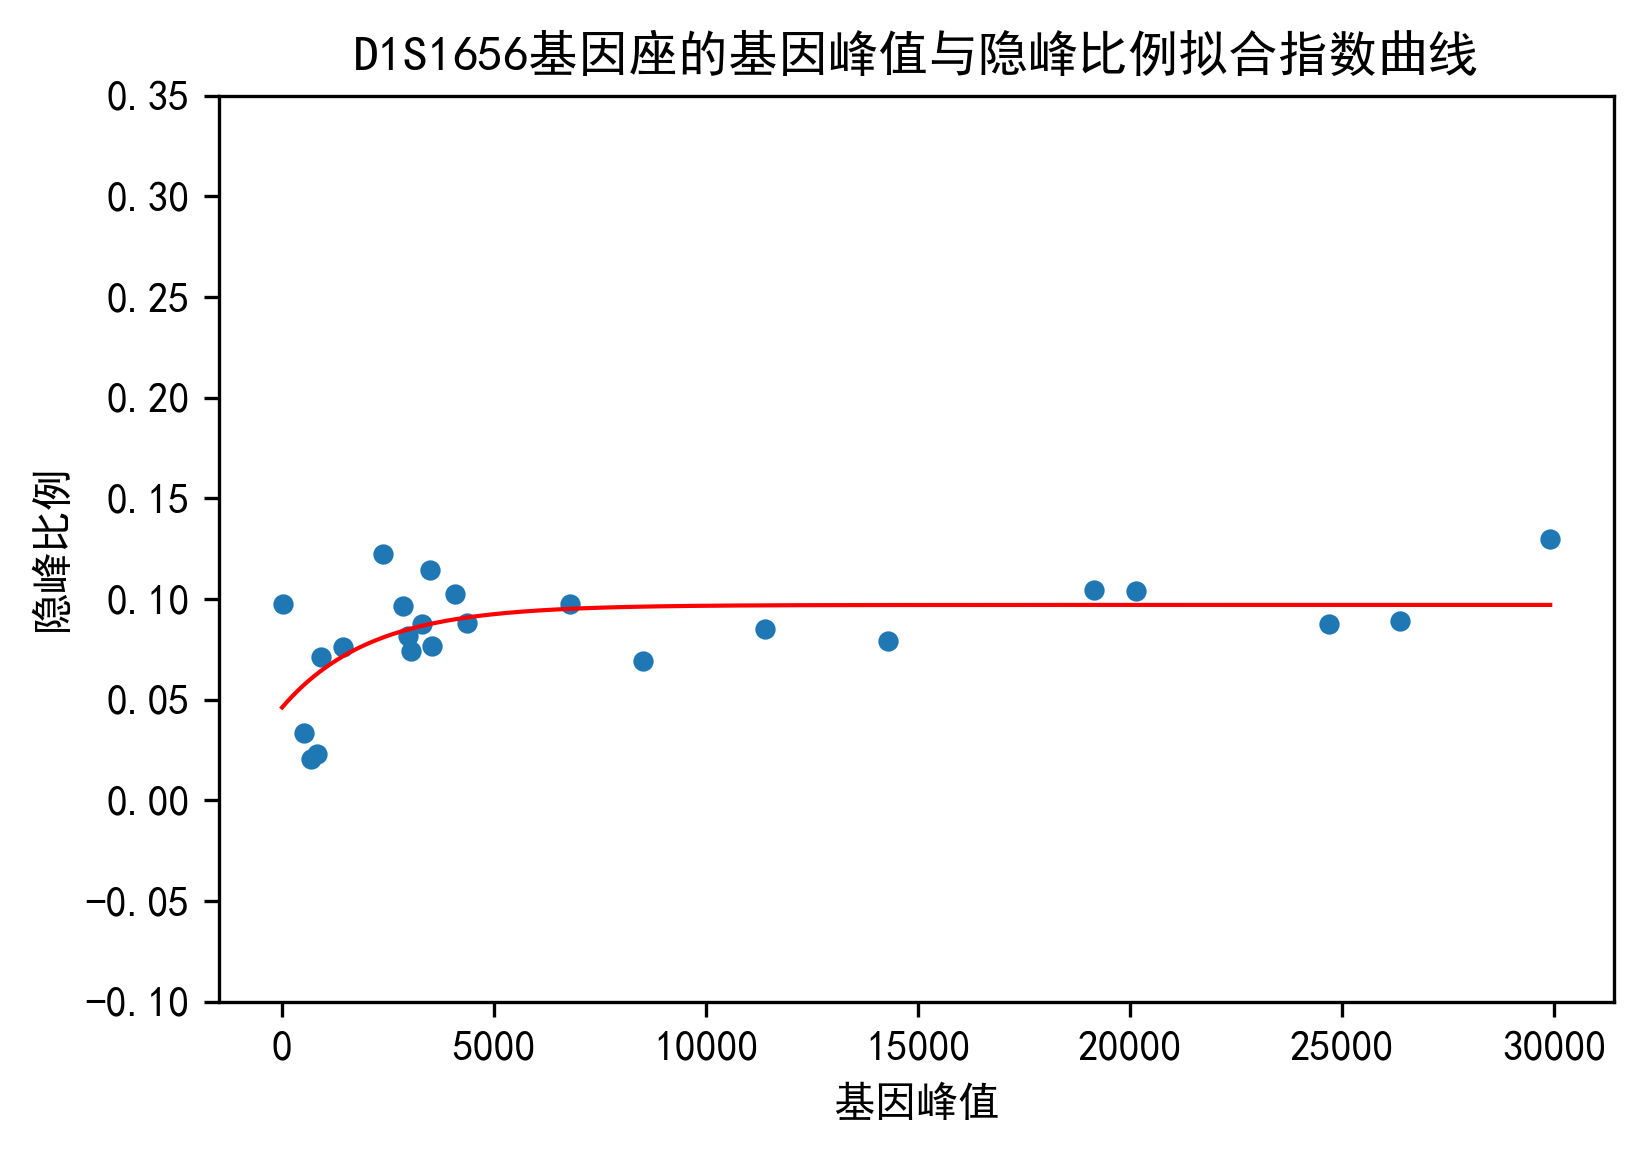

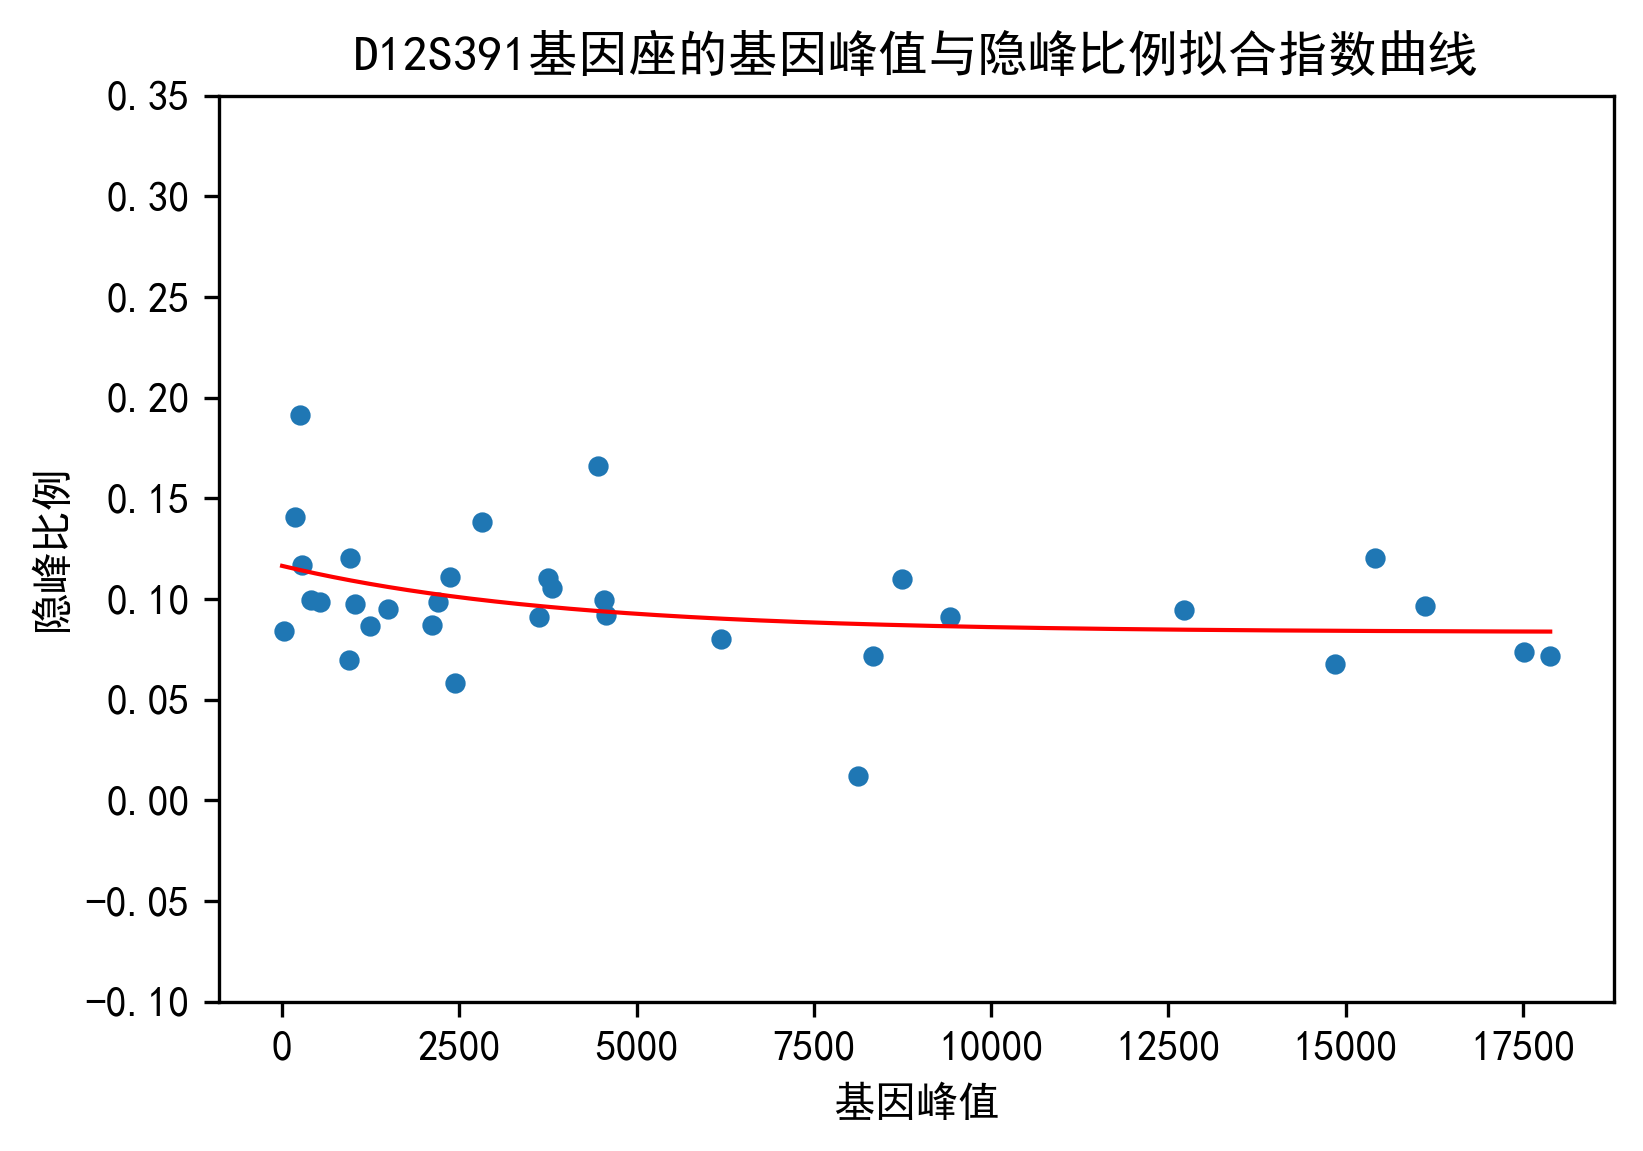

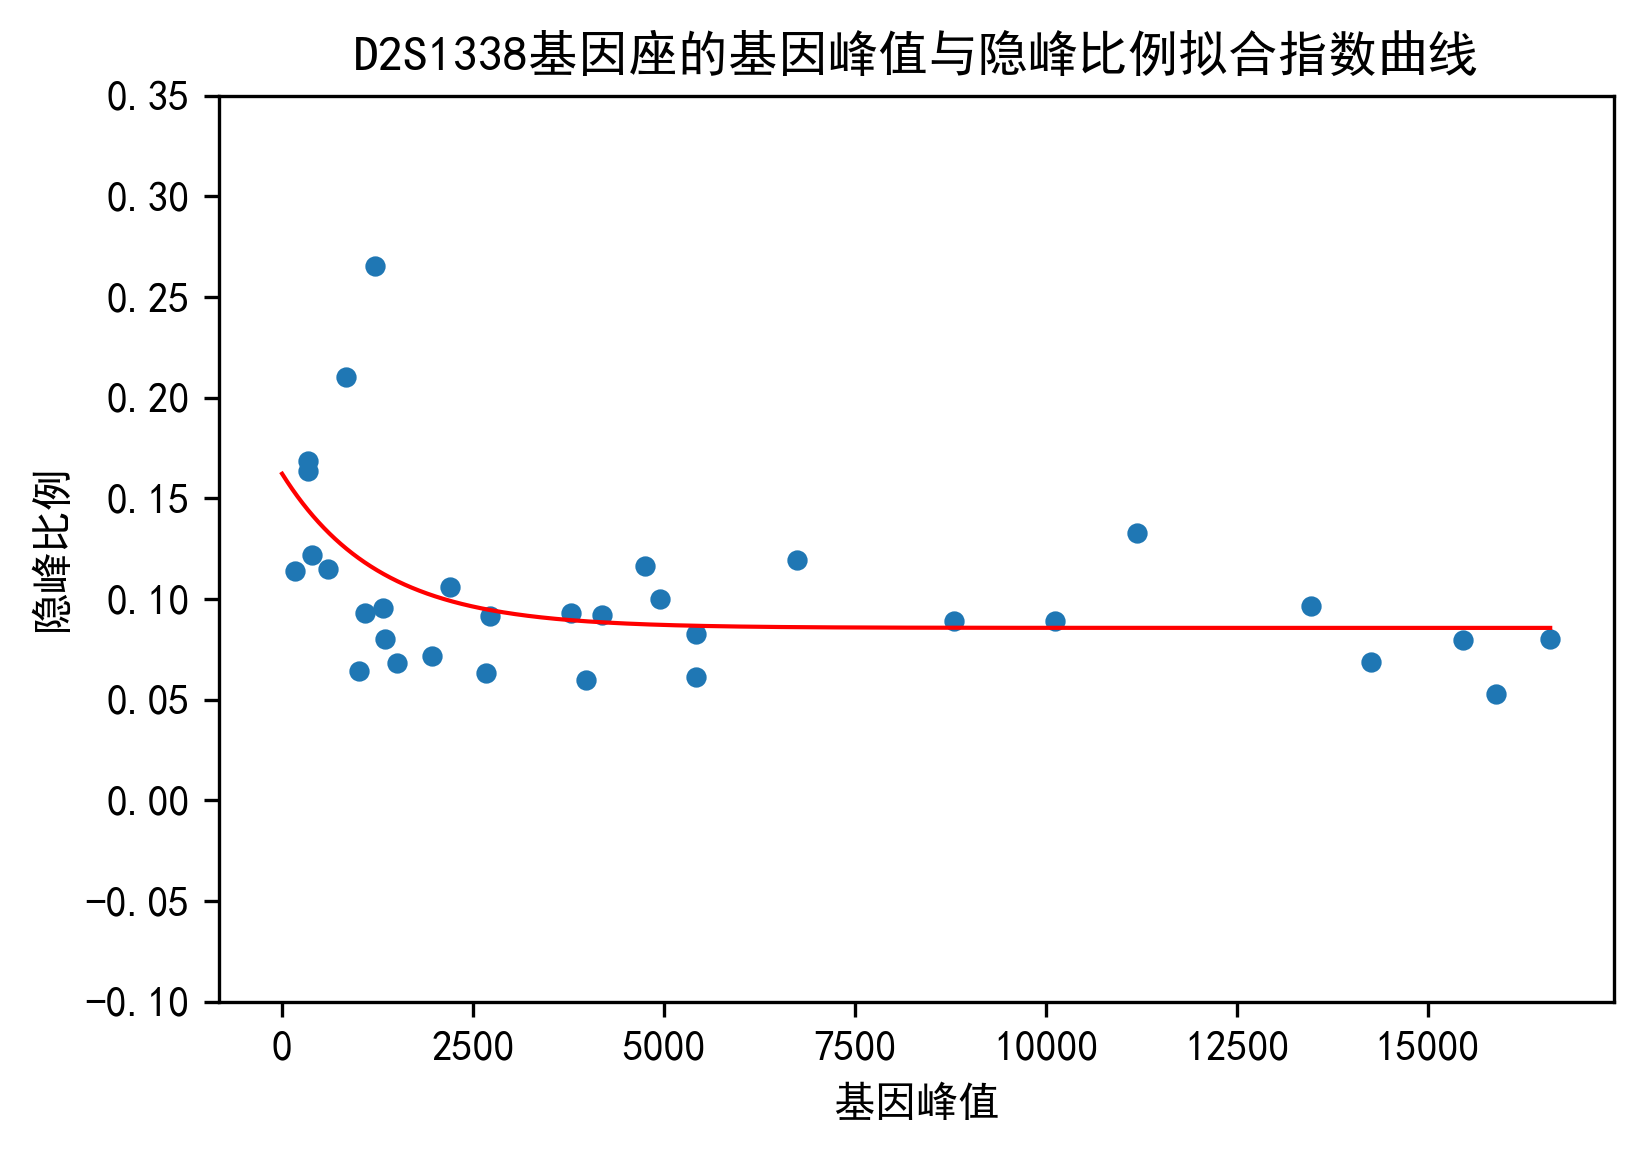

In [3]:

params = {'marker': [], 'a0': [], 'a1': [], 'a2':[]}
# radio阈值
radio_gate = 0.3
for marker in alleles_dict.keys():
    height_list = []
    ratio_list = []
    for index, person in enumerate(persons):
        alleles = alleles_dict_list[index][marker]
        for num in nums:
            init_data = pd.read_csv(f'data/单个个体/{person}{num}pg.hid_Genotype.csv', usecols=['Marker', 'Allele', 'Height', 'Size'], dtype={"Allele": str, "Height": float})
            init_data = init_data[(init_data['Size'] != 'Dropout') & ~(init_data['Marker'].isin(delete_list))]
            init_data['Height'] = init_data['Height'].apply(pd.to_numeric, errors='coerce').fillna(0.0)

            if len(alleles) == 2:

                alleles_data = init_data[(init_data['Marker'] == marker) & (init_data['Allele'].isin(alleles))]
                for height in alleles_data['Height']:
                    height_list.append(height)
                
                for ii in range(len(alleles_data)):
                    stuff_index = alleles_data.index[ii]-1
                    while True:
                        if stuff_index in init_data.index:
                            radio = init_data.loc[stuff_index, 'Height'] / alleles_data['Height'].values[ii]
                            if radio < radio_gate:
                                ratio_list.append(radio)
                            else:
                                height_list.pop()
                            break
                        else:
                            stuff_index -= 1

            
            elif len(alleles) == 1:
                alleles_data = init_data[(init_data['Marker'] == marker) & (init_data['Allele'].isin(alleles))]
                for height in alleles_data['Height']:
                    height_list.append(height / 2)
                stuff_index = alleles_data.index[0]-1
                while True:
                    if stuff_index in init_data.index:
                        radio = init_data.loc[stuff_index, 'Height'] / alleles_data['Height'].values[0]
                        if radio < radio_gate:
                            ratio_list.append(radio)
                        else:
                            height_list.pop()
                        break
                    else:
                        stuff_index -= 1
    plt.figure(dpi=300)
    plt.scatter(height_list, ratio_list, s=15)
    plt.ylim(-0.1, 0.35)
    len(height_list)

    x = np.array(height_list)
    y = np.array(ratio_list)

    # 拟合指数曲线
    def target_func(x, a0, a1, a2):
        return a0 * np.exp(-x / a1) + a2

    a0 = max(y) - min(y)
    a1 = x[round(len(x) / 2)]
    a2 = min(y)
    p0 = [a0, a1, a2]

    para, cov = optimize.curve_fit(target_func, x, y, p0=p0, maxfev=10000)
    params['marker'].append(marker)
    params['a0'].append(para[0])
    params['a1'].append(para[1])
    params['a2'].append(para[2])


    x_list = [i for i in range(0, int(max(x)))]

    y_fit = [target_func(a, *para) for a in x_list]

    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['font.family']='sans-serif' #解决负号'-'显示为方块的问题
    matplotlib.rcParams['axes.unicode_minus'] = False
    plt.title(f'{marker}基因座的基因峰值与隐峰比例拟合指数曲线')
    plt.xlabel('基因峰值')
    plt.ylabel('隐峰比例')
    plt.plot(x_list, y_fit, 'r-', linewidth=1)

    with open(f'img/指数/{marker}.png','wb') as f:  
        plt.savefig(f, format='png', dpi=300)

pd.DataFrame(params).to_csv('img/指数/指数拟合参数.csv', index=False)